# Cross-Condition Analysis

In [1]:
import sys
!{sys.executable} -m pip install --quiet decoupler liana requests ipywidgets

In [2]:
from pathlib import Path
import os
import requests
import gc

import pandas as pd
import scanpy as sc
import seaborn as sns
import partipy as pt
import decoupler as dc

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## ParTIpy Analysis of on non-classical Monocytes from Lupus Data - Introduction

Cells of the same type often exhibit a continuum of gene expression states, reflecting their functional diversity and adaptability. The Pareto task optimality theory provides a framework to interpret this variability by organizing cells within a low-dimensional polytope in gene expression space. The vertices of this polytope represent specialized "archetypes"—cells optimized for specific tasks performed by the cell type.

Given this theoretical foundation, archetypal analysis is most meaningful when applied to a single cell type. In this vignette, we focus specifically on **non-classical monocytes** to explore their gene expression patterns and uncover the underlying task specialization from their transcriptional profiles. As algorithm for the archetypal analysis we will use PCHA with random initialization.

## Load Data


In [3]:
data_dir = Path(".") / "data"
data_dir.mkdir(exist_ok=True)

# File URL to download
url = "https://datasets.cellxgene.cziscience.com/4532eea4-24b7-461a-93f5-fe437ee96f0a.h5ad"
filename = data_dir / os.path.basename(url)

# Download file if it does not already exist
if not filename.exists():
    response = requests.get(url, stream=True)
    response.raise_for_status()
    
    with open(filename, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    
    print(f"Downloaded: {filename}")
else:
    print(f"File already exists, skipping: {filename}")

File already exists, skipping: data/4532eea4-24b7-461a-93f5-fe437ee96f0a.h5ad


In [4]:
adata = sc.read_h5ad(data_dir / "4532eea4-24b7-461a-93f5-fe437ee96f0a.h5ad")
adata = adata[adata.obs["author_cell_type"]=="ncM", :].copy()
adata = adata[adata.obs["disease_state"] != "na", :].copy() # remove missing disease status
# remove columns we don't need
adata.obs.drop(columns=["mapped_reference_annotation", "cell_type_ontology_term_id", "is_primary_data", 
                        "cell_state", "tissue_ontology_term_id", "development_stage_ontology_term_id", 
                        "tissue", "organism", "tissue_type", "suspension_type", "organism_ontology_term_id",
                        "assay_ontology_term_id", "suspension_enriched_cell_types", "suspension_uuid",
                        "self_reported_ethnicity_ontology_term_id", "disease_ontology_term_id",
                        "sex_ontology_term_id"], 
                        inplace=True)
# create new index
adata.obs.index = [s.split("-")[0] + "-" + str(len(s.split("-"))) + "-" + str(donor_id) 
                   for s, donor_id in zip(adata.obs.index, adata.obs["donor_id"].to_list())]
# remove obsm we don't need
del adata.obsm["X_pca"], adata.obsm["X_umap"], adata.uns
gc.collect()

# use the raw counts
adata.X = adata.raw.X

# use gene symbols instead of ensembl IDs
assert len(adata.var["feature_name"]) == len(adata.var["feature_name"].unique())
adata.var = adata.var.set_index("feature_name")

adata

/Users/pschafer/miniforge3/envs/partipy/lib/python3.11/site-packages/anndata/_core/anndata.py:750: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['MIR1302-2HG', 'FAM138A', 'OR4F5', 'ENSG00000238009.6', 'ENSG00000239945.1']

    Inferred to be: categorical



AnnData object with n_obs × n_vars = 33709 × 30867
    obs: 'library_uuid', 'author_cell_type', 'sample_uuid', 'disease_state', 'donor_id', 'Processing_Cohort', 'ct_cov', 'ind_cov', 'cell_type', 'assay', 'disease', 'sex', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'

## Quality Control

We follow the Scanpy [tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html) to perform quality control on our dataset
We first compute the proportion of counts originating from mitochondrial, ribosomal, and hemoglobin genes:

In [5]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [6]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

We can now examine key quality control metrics, including:
- The number of genes expressed per cell
- The total counts per cell
- The percentage of counts originating from mitochondrial genes

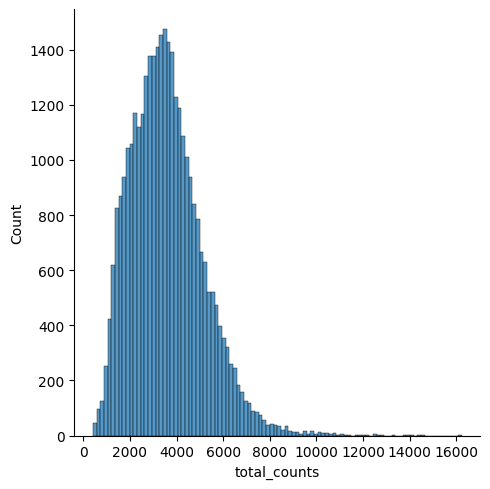

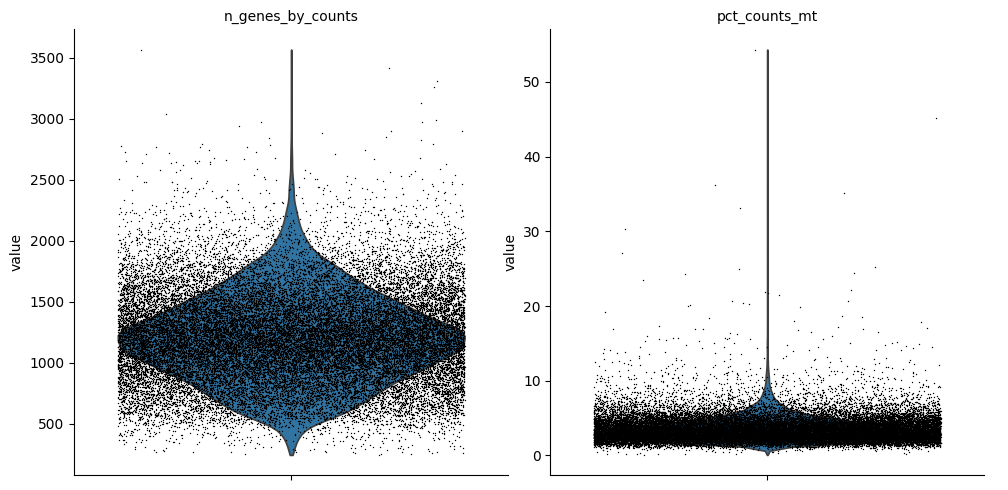

In [7]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

To remove low-quality data, we filter out cells with fewer than 100 detected genes and genes that are present in fewer than 3 cells. This ensures that only high-quality cells and genes are retained for downstream analysis.

In [8]:
print(f"Number of cells before filtering: {adata.n_obs} \nNumber of genes before filtering: {adata.n_vars}")
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
print(f"Number of cells after filtering of low quality cells: {adata.n_obs} \nNumber of genes after filtering of low quality genes: {adata.n_vars}")

Number of cells before filtering: 33709 
Number of genes before filtering: 30867
Number of cells after filtering of low quality cells: 33709 
Number of genes after filtering of low quality genes: 17477


## Normalization and feature selection

To ensure comparability across cells, we normalize the data to the median total counts per cell and apply a logarithmic transformation:

In [9]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

ANext, we identify highly variable genes, which are key for downstream analysis. We also visualize them to assess their distribution:

In [10]:
sc.pp.highly_variable_genes(adata)

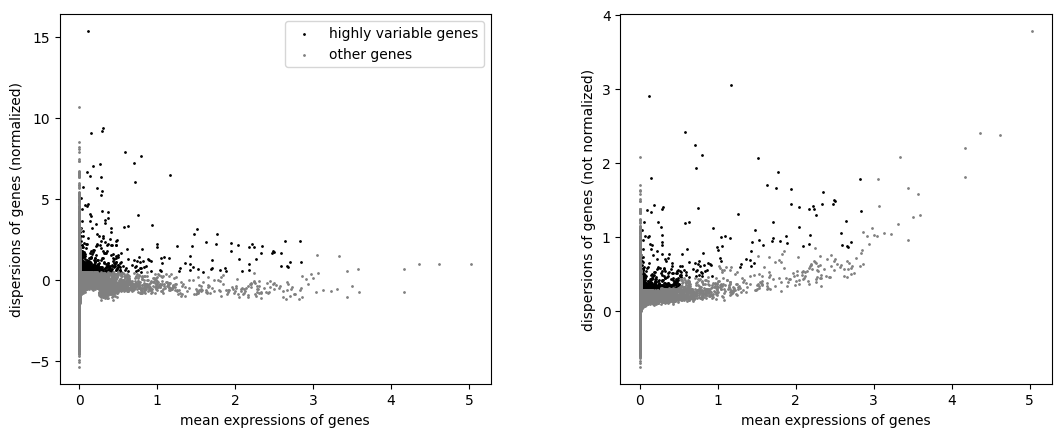

In [11]:
sc.pl.highly_variable_genes(adata)

For downstream enrichment analysis, we standardize the data by scaling gene expression values:

In [12]:
adata.layers["z_scaled"]= sc.pp.scale(adata.X, max_value=10)

## Dimension Reduction

We compute Principal Component Analysis (PCA) using only highly variable genes and visualize the results:

In [13]:
sc.pp.pca(adata, mask_var="highly_variable")

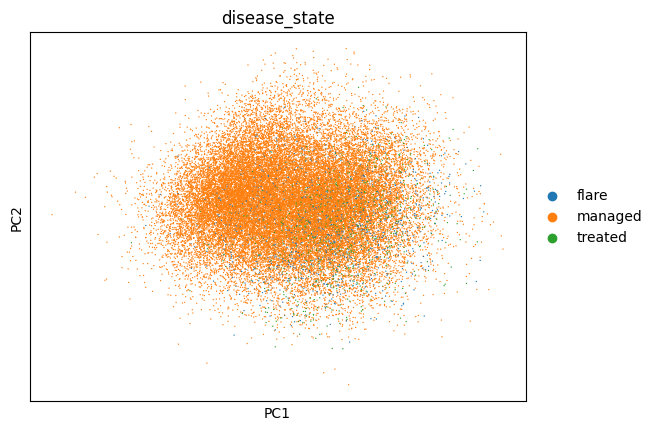

In [14]:
sc.pl.pca_scatter(adata, color="disease_state")

To determine the optimal number of principal components (PCs) to retain, we inspect their contribution to the total variance:

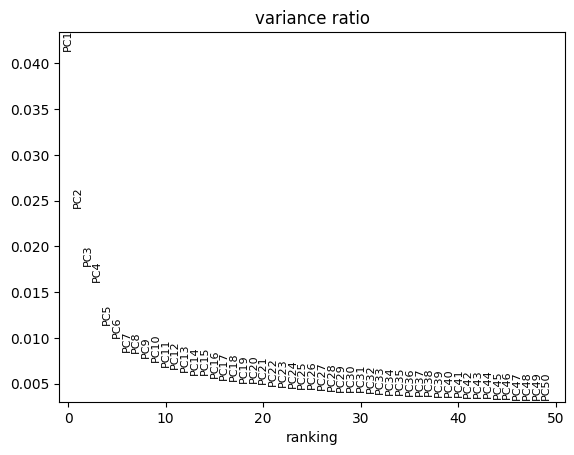

In [15]:
sc.pl.pca_variance_ratio(adata, n_pcs=50)

Based on this, we select 7 PCs, as the variance explained plateaus beyond this point.

In [16]:
n_pcs = 7

For ease of use in downstream analysis, we store the number of dimensions in adata.uns["n_pcs"] with the following function:

In [17]:
pt.set_dimension_aa(adata=adata, n_pcs=n_pcs)

## Number of Archetypes

Next, we need to determine the optimal number of archetypes in our data—essentially, the number of vertices in the polyhedron.

We first assess how much variance is explained for different numbers of archetypes.

The function var_explained_aa() takes the reduced PCA data and calculates the explained variance for a range of archetypes (min_a to max_a). Additionally, it computes:

- The variance explained by each archetype.
- The additional variance explained by each successive archetype.
- The distance from the projected point to the line of the elbow plot.

In [18]:
pt.var_explained_aa(adata=adata, min_a=2, max_a=10)

The results are stored in:

In [19]:
adata.uns["AA_var"]

k   varexpl  varexpl_ontop  dist_to_projected
0   2  0.318308       0.318308           0.000000
1   3  0.497615       0.179307           0.105616
2   4  0.608438       0.110822           0.142930
3   5  0.691109       0.082672           0.152169
4   6  0.761949       0.070840           0.149609
5   7  0.806838       0.044888           0.121167
6   8  0.860174       0.053336           0.101149
7   9  0.884295       0.024121           0.051995
8  10  0.905568       0.021273           0.000000

We visualize the explained variance for different models:

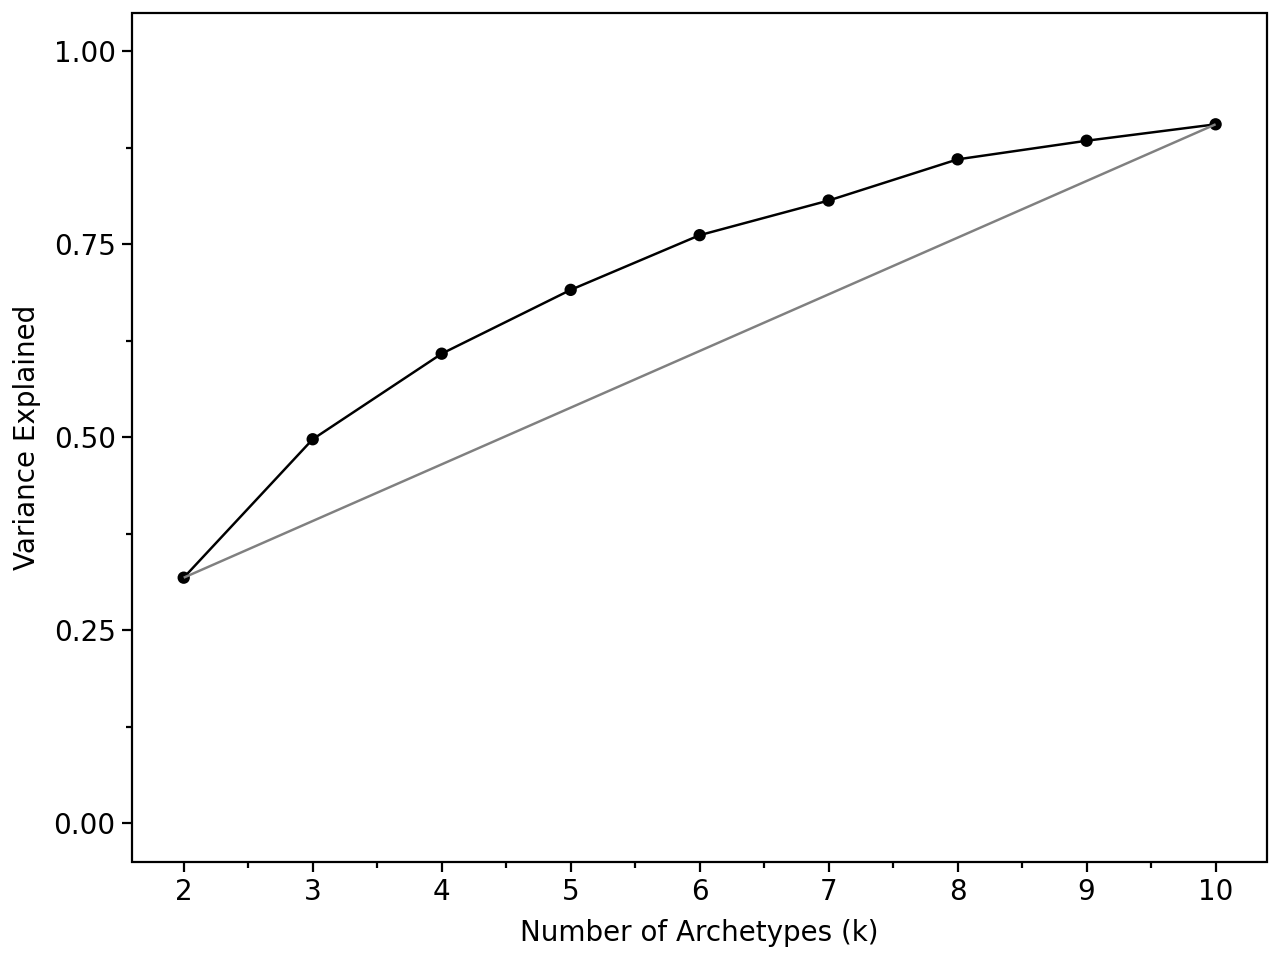

In [20]:
pt.plot_var_explained(adata)

In this plot, the grey line connects the first and last variance explained (EV) values, helping to identify the "elbow" of the black curve.

This analysis suggests that the best choice is 4-6 archetypes. We decide to use 4 archetypes, as later analyses show that the 5th archetype introduces no new tasks.

In [21]:
n_archetypes = 4

To validate the archetype stability, we apply bootstrapping. We sample the data five times (for efficiency) and run Archetypal Analysis (AA) on each sample. 

In [22]:
pt.bootstrap_aa(adata=adata, n_bootstrap=5, n_archetypes=n_archetypes)

The positions of the archetypes and the mean variance across all bootstrapped samples are stored in:

In [23]:
adata.uns["AA_bootstrap"]

pc_0      pc_1      pc_2      pc_3      pc_4      pc_5      pc_6  \
0 -0.900619  4.603336  1.113584  0.549358 -0.106852 -0.362949  0.308531   
1  3.786006 -2.267767  2.840239  0.737072  0.226919 -0.349324 -0.015607   
2  4.456161  0.345370 -4.495770 -1.576708 -0.265138  1.050652 -0.412841   
3 -5.269717 -2.742835 -1.073100 -0.265497  0.064925  0.268985  0.099280   
0 -1.555719  2.951049  3.293071  0.730057 -0.240608 -0.010334  0.272386   
1  5.068760 -2.980037  0.921720  0.063768  0.309363 -0.064614 -0.356140   
2  2.127087  3.783119 -3.263491 -0.531284 -0.081028  0.234200  0.082982   
3 -5.283842 -3.032476 -1.542019 -0.348231  0.035508  0.144203  0.168129   
0  0.559072  3.354389  3.570890  0.055416 -0.971098  0.077459 -0.122439   
1  2.349004 -4.953372  1.370341  0.265469 -0.260504 -0.086795  0.058805   
2  3.964918  2.368157 -3.126773 -0.411437  0.674882  0.107991  0.012370   
3 -4.948226 -0.487907 -1.281855  0.101348  0.444580  0.126437  0.040251   
0  0.399966  2.473843  3.937101  0.443835 -0.628056 -0.072950  0.160133   
1  5.417054 -3.123000 -0.174173 -0.058462  0.249374  0.053355 -0.269732   
2  0.331886  3.848495 -3.277423 -0.330344  0.224477  0.028077  0.009843   
3 -4.875031 -1.860058 -0.473530 -0.116710  0.078146  0.290883  0.193932   
0 -0.467547  3.040482  3.185820  0.532213 -0.521785 -0.076617  0.119351   
1  4.822158 -3.484320  0.744608  0.092561  0.219242  0.121649 -0.257329   
2  2.103200  3.689995 -3.171870 -0.496665  0.028963  0.061741  0.078085   
3 -5.241519 -2.599342 -1.128573 -0.227704  0.269317  0.186320  0.112032   
0  0.010703  3.460507  3.376966 -0.119943 -0.682076  0.068231  0.061964   
1  3.244555 -4.678273  1.551758 -0.116237 -0.056357 -0.087140 -0.155480   
2  3.758055  2.574008 -3.206294  0.120228  0.333605  0.043828 -0.018604   
3 -5.240859 -1.145358 -1.428620  0.066964  0.368025  0.205923  0.091438   

  archetype  iter  reference  mean_variance  
0         0     1      False       0.403188  
1         1     1      False       0.403188  
2         2     1      False       0.403188  
3         3     1      False       0.403188  
0         0     2      False       0.403188  
1         1     2      False       0.403188  
2         2     2      False       0.403188  
3         3     2      False       0.403188  
0         0     3      False       0.403188  
1         1     3      False       0.403188  
2         2     3      False       0.403188  
3         3     3      False       0.403188  
0         0     4      False       0.403188  
1         1     4      False       0.403188  
2         2     4      False       0.403188  
3         3     4      False       0.403188  
0         0     5      False       0.403188  
1         1     5      False       0.403188  
2         2     5      False       0.403188  
3         3     5      False       0.403188  
0         0     0       True       0.403188  
1         1     0       True       0.403188  
2         2     0       True       0.403188  
3         3     0       True       0.403188

We visualize the bootstrapping results:

In [24]:
pt.plot_bootstrap_3D(adata)

The results show that the archetypes are mostly stable, supporting our selection. 

## Archetype Analysis and visualization

Now that we've determined the number of archetypes, we can compute the four archetypes and save them to our AnnData object:

In [25]:
pt.compute_archetypes(adata, n_archetypes, init="furthest_sum", max_iter=100)

The results including the archetypes are stored in:

In [26]:
adata.uns["archetypal_analysis"]

{'Z': array([[ 0.01070297,  3.4605074 ,  3.376966  , -0.11994255, -0.6820757 ,
          0.06823075,  0.06196353],
        [ 3.2445552 , -4.678273  ,  1.551758  , -0.11623686, -0.05635709,
         -0.08714024, -0.1554796 ],
        [ 3.758055  ,  2.5740082 , -3.2062936 ,  0.12022752,  0.33360454,
          0.04382796, -0.01860411],
        [-5.2408586 , -1.145358  , -1.4286205 ,  0.0669641 ,  0.3680248 ,
          0.2059226 ,  0.09143821]], dtype=float32)}

We store the archetype matrix in Z for potential future analysis, such as subsetting for plotting:

In [27]:
Z = adata.uns["archetypal_analysis"]["Z"]

We can visualize the polytope in both 2D and 3D. We want the colors to represent the disease status.
Alternatively, we can color the plot based on a gene with distinct expression across archetypes. For example, using the gene IFI27.

We visualize the polytope in 2D with the following:

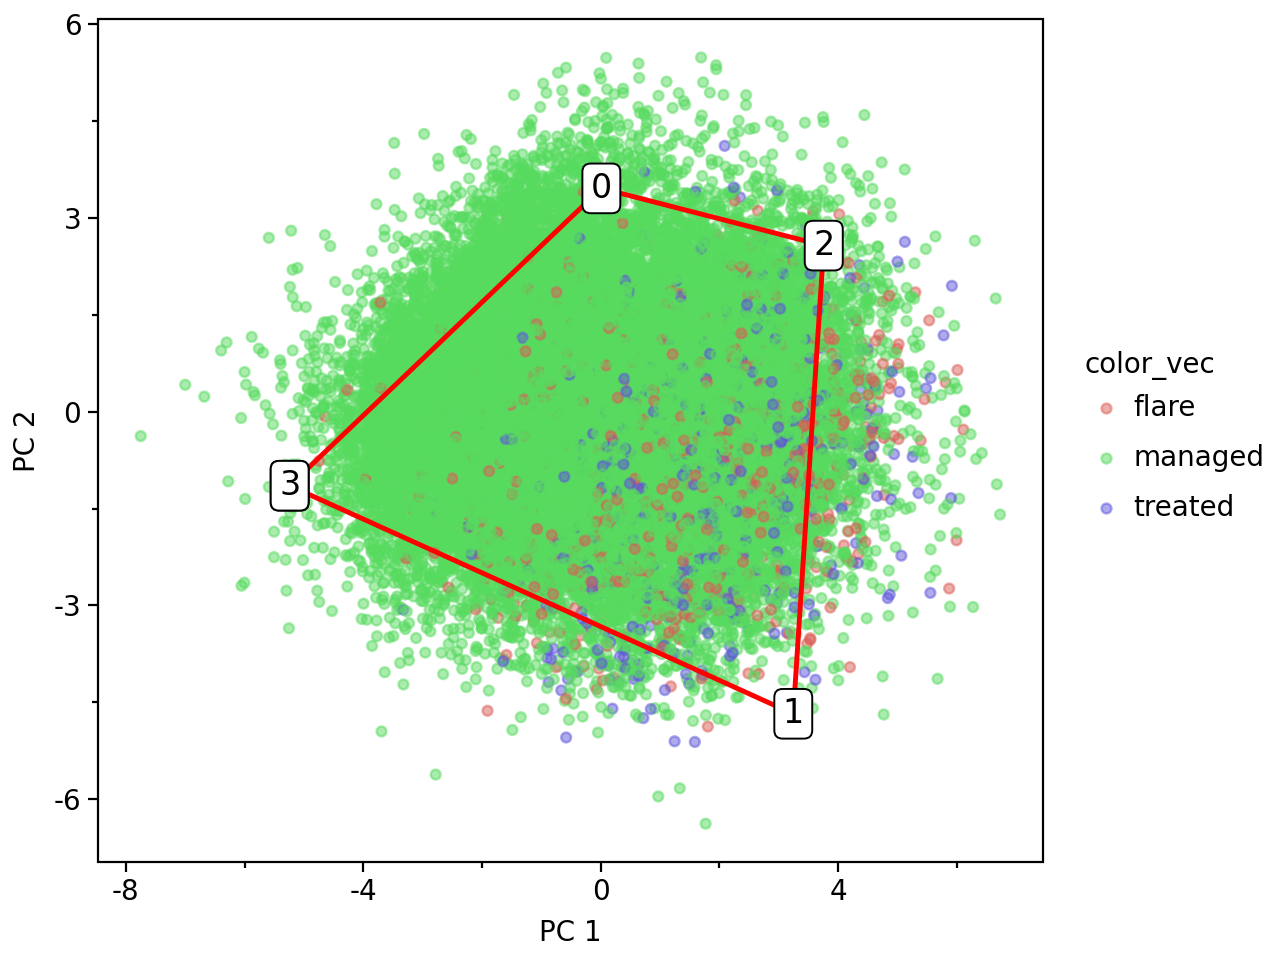

In [28]:
pt.plot_archetypes_2D(adata=adata, color="disease_state")

For a 3D representation, we can plot the data along with the archetypes in a 3D space. You may choose to subset the data if necessary:

In [29]:
pt.plot_archetypes_3D(adata=adata, color="disease_state")

To further evaluate the significance of the polytope, we plan to calculate the t-ratio. This is the ratio of the volume of the volume of the polytope formed by the archetypes over the volume of the convex hull of the data. Therefore results closer to 1 are desireable.

In [30]:
pt.compute_t_ratio(adata)
adata.uns["t_ratio"]

0.09800988189448734

To calculate the significance of our polytope, we shuffle the expression of the higly variable genes independently, calculate the PCA, new archetypes and t-ratio. The p-value is then the number of times the t-ratio of shuffled data is greater than the t-ratio on the original data divided by the number of iterations.

In [31]:
# TODO
# t_ratio_significance_shuffled(adata, iter=1000)

## Identify representatives

To assign tasks to the archetypes, we need to identify cells that are representative of each archetype. To do this, we calculate a weighted pseudobulk for each archetype.

First, we calculate the weights for each cell based on its distance from the archetypes. The length scale of the RBF kernel is automatically set as half the median distance from the data centroid to the archetypes. However, this can also be manually adjusted if needed:

In [32]:
pt.compute_archetype_weights(X=adata, mode="automatic")

Applied length scale is 2.787625148696474.


We can visualize the cell weights for each archetype to assess their distribution:

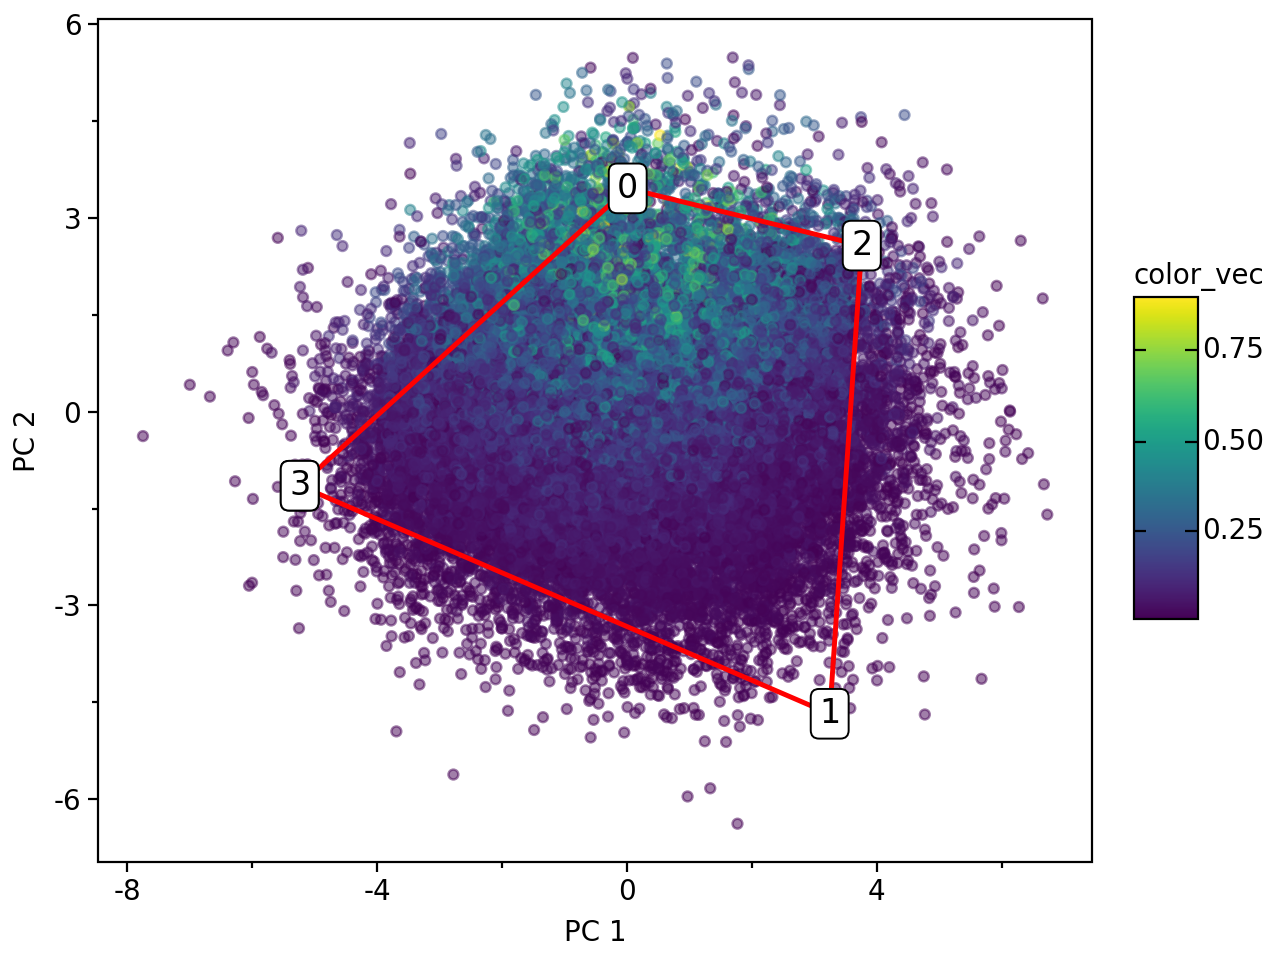

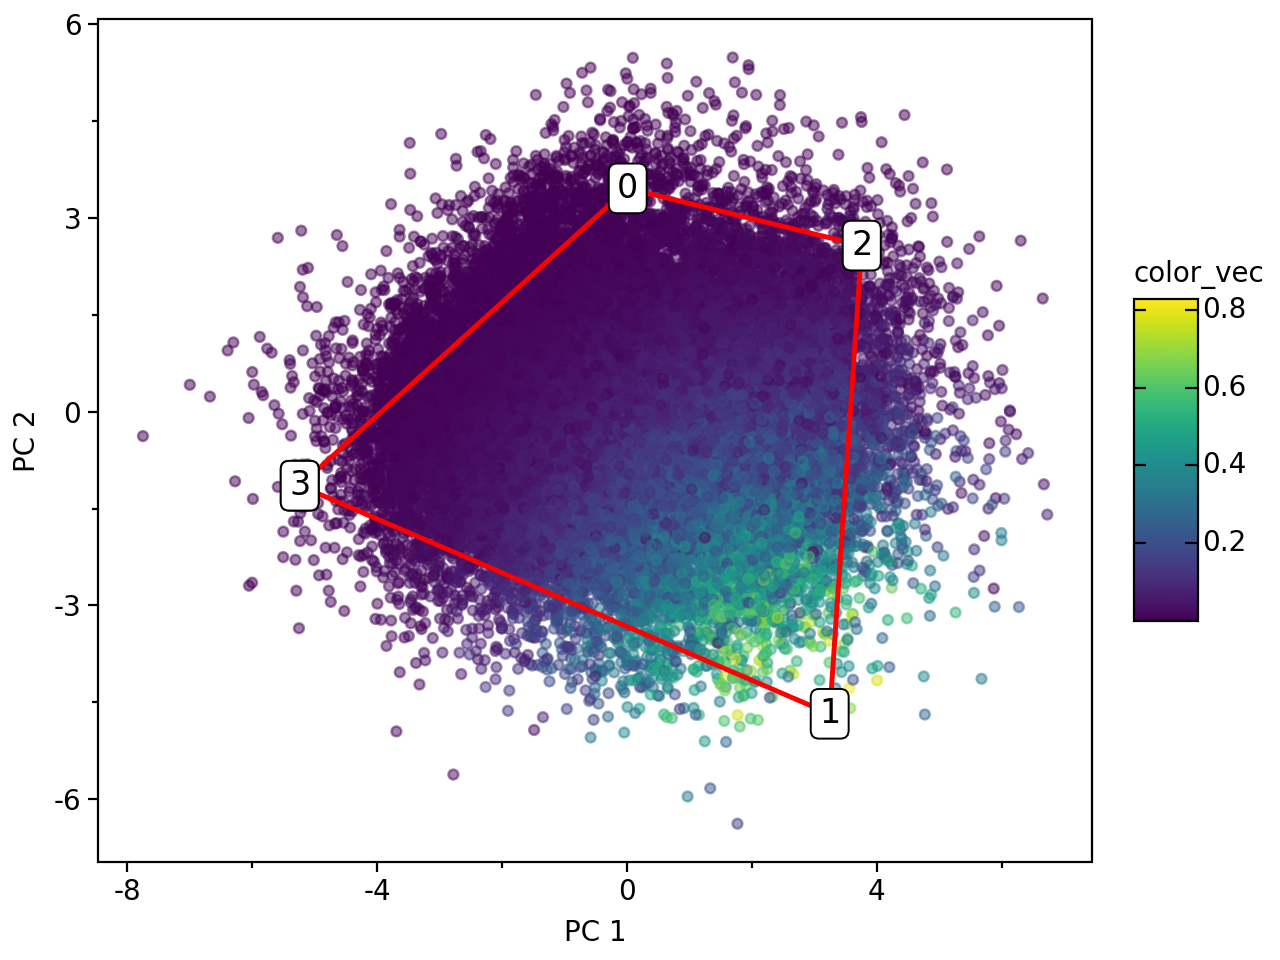

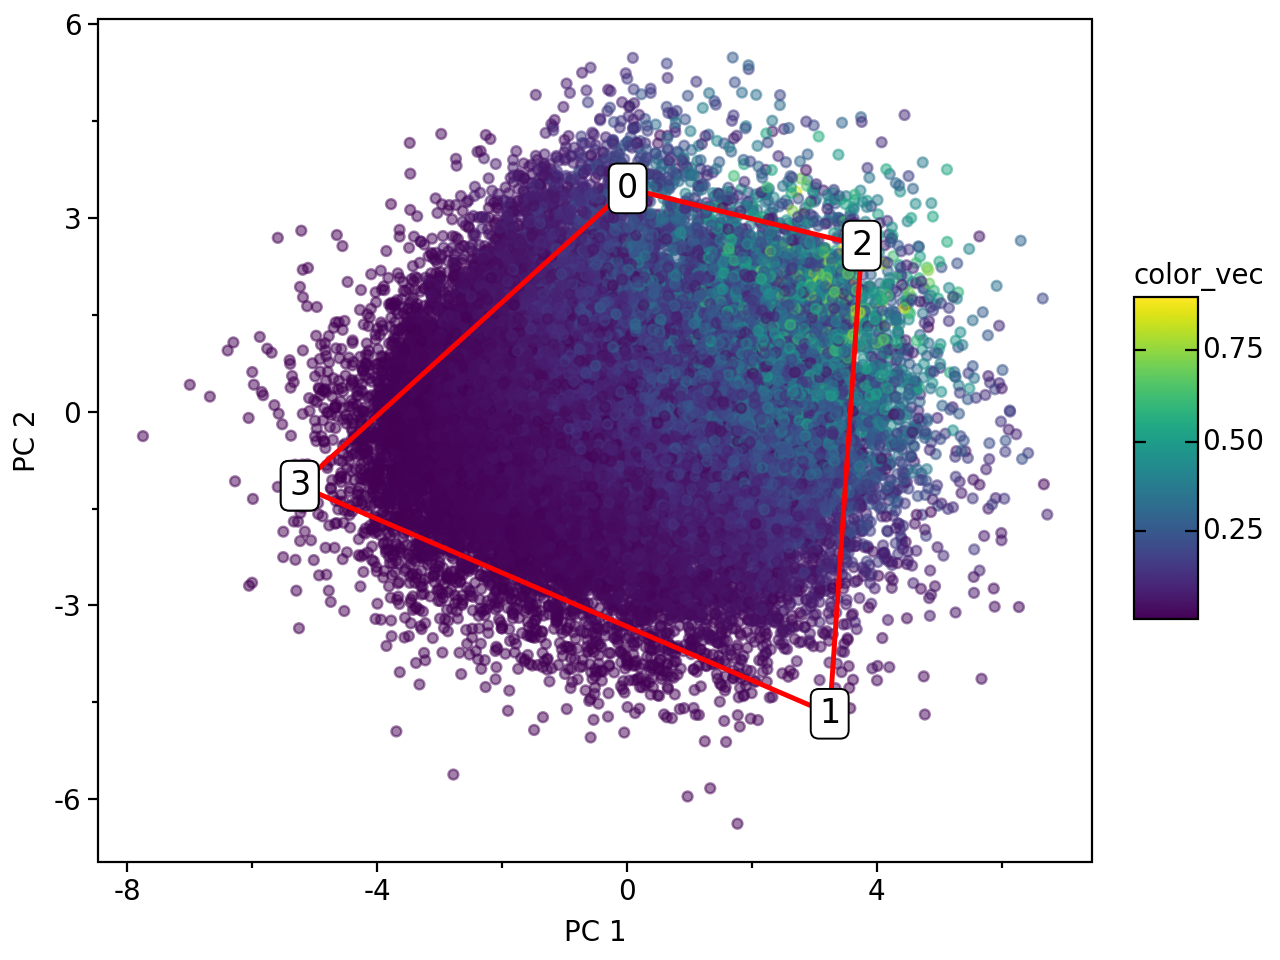

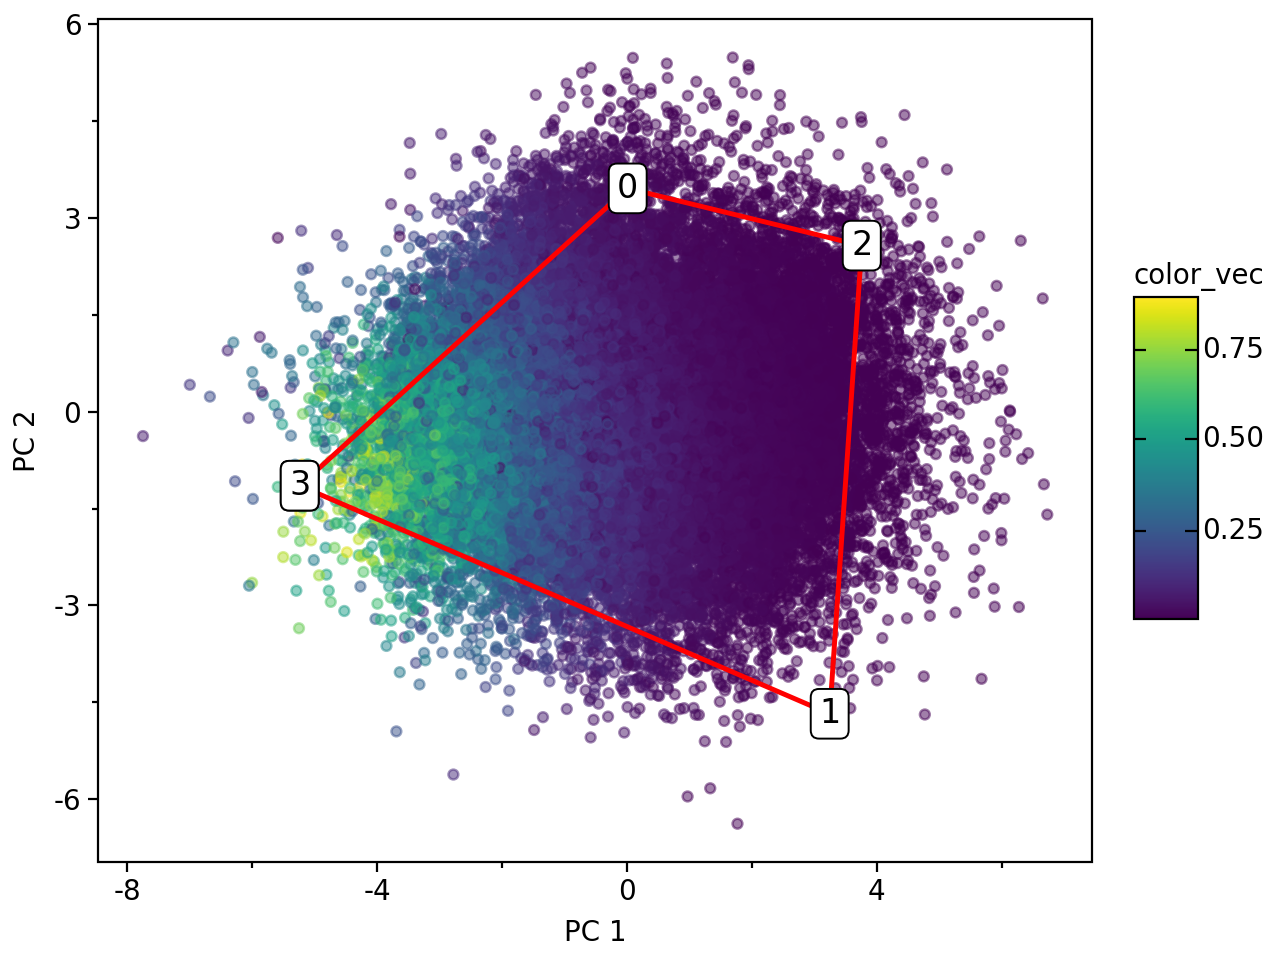

In [33]:
for i in range(0,4):
    plt = pt.plot_2D(adata.obsm["X_pca"], Z = Z, color_vec=adata.obsm["cell_weights"].T[i])
    plt.show()

## Enrichment Metadata

With the weights we can now calculate enrichment of interest. Since we have different cell status associated with healthy and disease, we want first to check the enrichment by the "disease_state and find our archetypes of interest.

meta_enrichment() calcualtes the enrichment of any specified metadata stored in obs. 

In [34]:
status_enrichment = pt.compute_meta_enrichment(adata=adata, meta_col="disease_state")
status_enrichment

flare   managed   treated
0  0.253978  0.514927  0.231095
1  0.362268  0.213927  0.423805
2  0.350985  0.244136  0.404879
3  0.314319  0.481914  0.203766

We find ncM with the "Flare" status enriched at archetype 0 and not associated with archetype 3. We can observe such distribution in the PCA space when plotting only the ncM with "Flare" status: 

In [35]:
flare_3D = pt.plot_3D(adata.obsm["X_pca"][:, :n_pcs][adata.obs["disease_state"] == "Flare"], Z)
flare_3D.show()

We can also visualize the results like this:

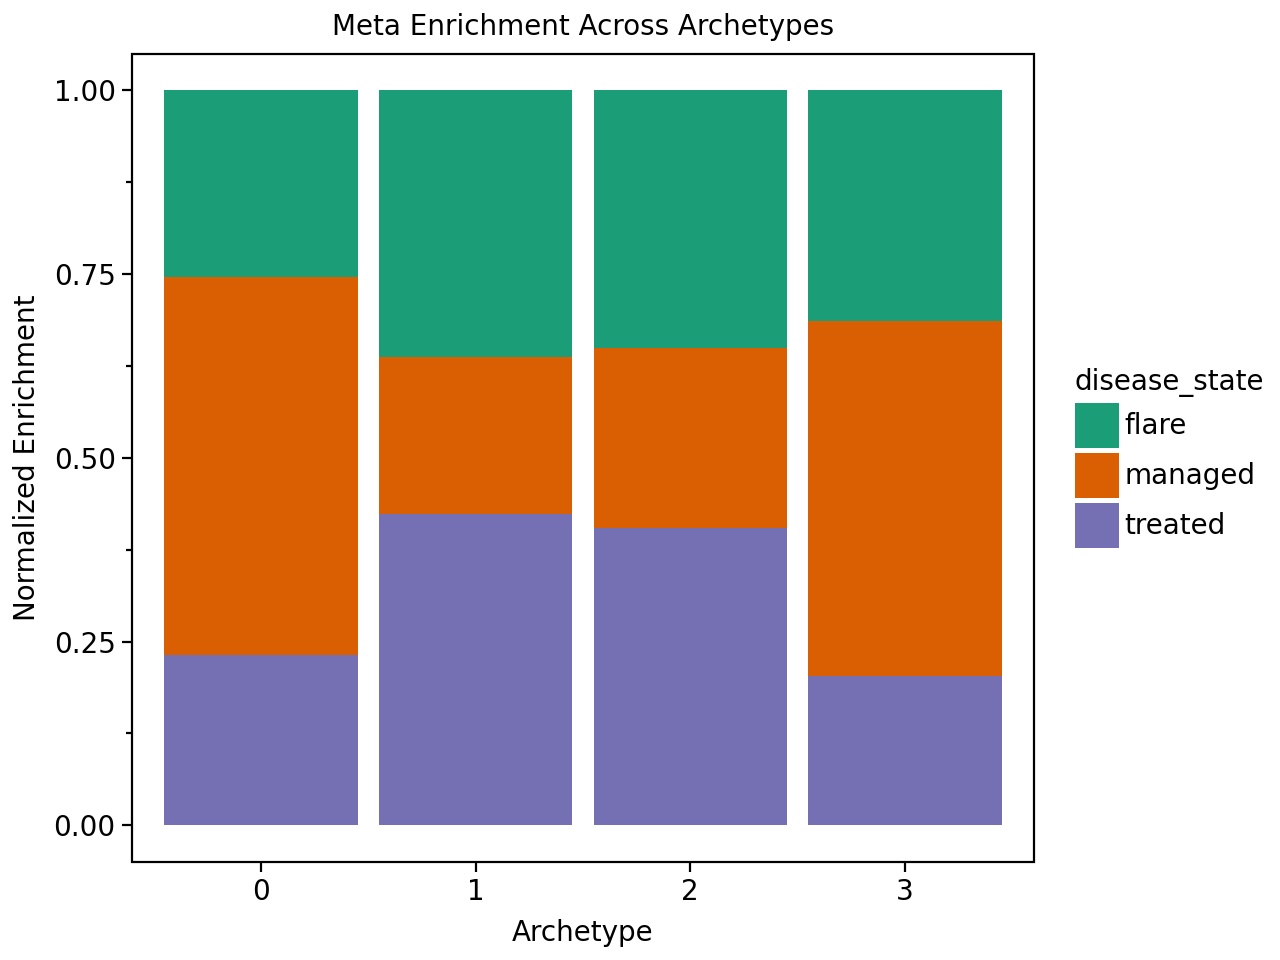

In [36]:
pt.barplot_meta_enrichment(status_enrichment, meta="disease_state")

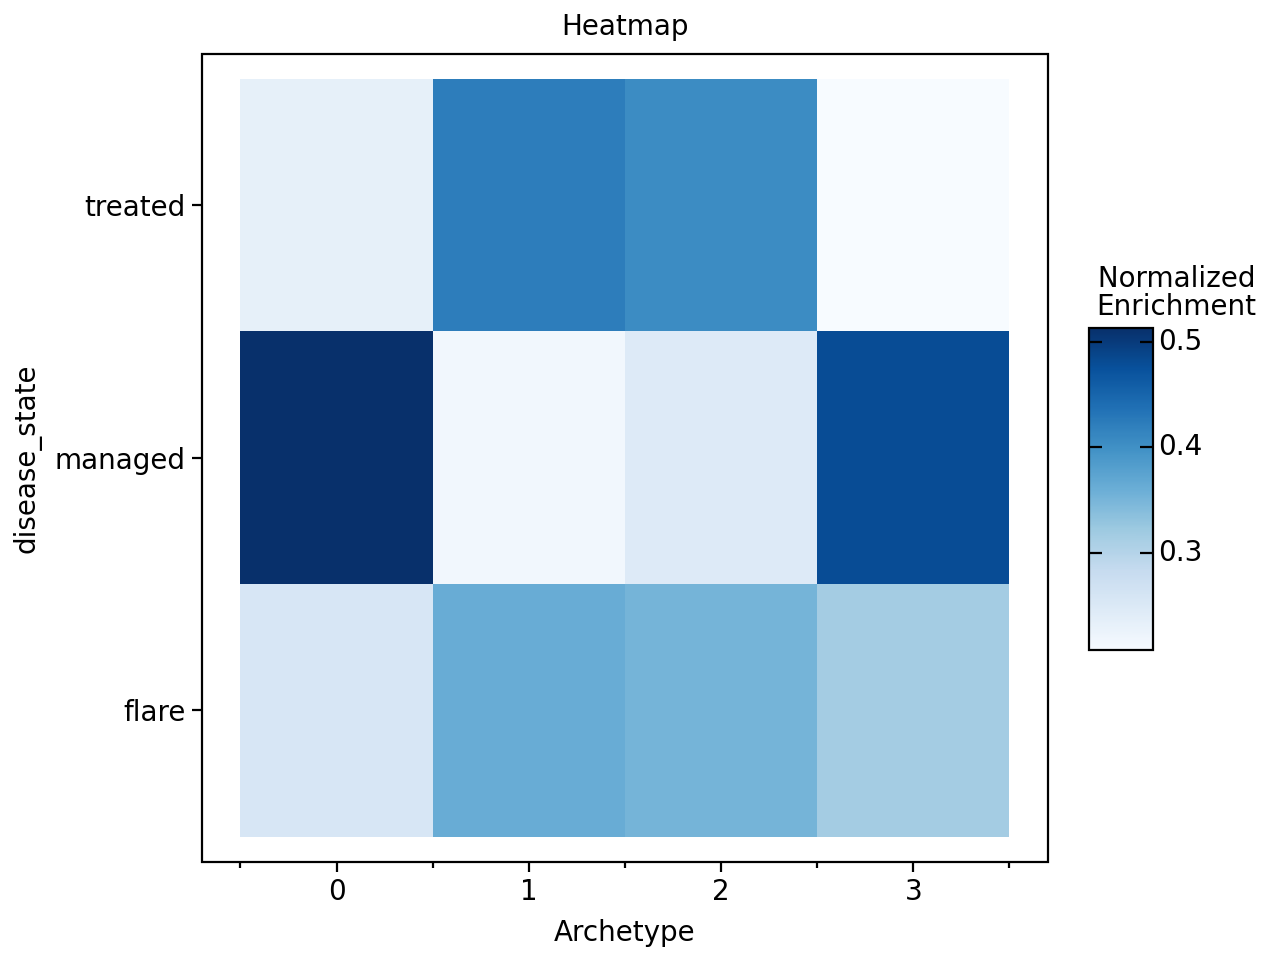

In [37]:
pt.heatmap_meta_enrichment(status_enrichment, meta="disease_state")

## Functional Enrichment MSigDB

Next, we compute a pseudobulk using the z-scaled gene expression data to observe differences in gene expression across the archetypes:

In [38]:
pseudobulk = pt.compute_archetype_expression(adata=adata, layer="z_scaled")

In [39]:
print(pseudobulk.head())

feature_name  ENSG00000238009.6  ENSG00000228463.10  ENSG00000237094.13  \
0                     -0.017475           -0.004786           -0.022548   
1                     -0.019365            0.008466           -0.021336   
2                     -0.020816           -0.005132           -0.016327   
3                     -0.021826           -0.001903           -0.021033   

feature_name  ENSG00000228327.6  LINC01409    FAM87B  LINC00115    FAM41C  \
0                      0.001460  -0.015876 -0.013925  -0.005247 -0.001686   
1                     -0.010193  -0.025174 -0.012755  -0.000804 -0.021730   
2                     -0.000408  -0.015096 -0.014682  -0.005156 -0.008958   
3                     -0.016999  -0.023470 -0.015082  -0.021987 -0.009263   

feature_name  ENSG00000230699.2    SAMD11  ...    MT-CO2   MT-ATP8   MT-ATP6  \
0                     -0.013144 -0.009112  ...  0.073626  0.030192  0.133493   
1                     -0.012978 -0.007381  ... -0.437564 -0.044990 -0.470126  

For functional enrichment, we use Decoupler with Gene Ontology (GO) biological processes. While other collections can be used, it’s recommended to choose those with less broad categories to avoid non-significant results.

We begin by loading the MSigDB resource and filtering for the GO biological processes collection:

In [40]:
msigdb_raw = dc.get_resource('MSigDB')
msigdb = msigdb_raw[msigdb_raw['collection']=='go_biological_process']
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

Next, we run ULM on the pseudobulk data using the filtered MSigDB resource. The results are saved in acts_ulm_est and acts_ulm_est_p:

In [41]:
acts_ulm_est_msigdb, acts_ulm_est_p_msigdb = dc.run_ulm(mat = pseudobulk,
                                net = msigdb,
                                weight = None,
                                source='geneset',
                                target='genesymbol')

acts_ulm_est_msigdb

GOBP_10_FORMYLTETRAHYDROFOLATE_METABOLIC_PROCESS  \
0                                         -0.270063   
1                                          0.160183   
2                                          0.098594   
3                                          0.342166   

   GOBP_2FE_2S_CLUSTER_ASSEMBLY  GOBP_2_OXOGLUTARATE_METABOLIC_PROCESS  \
0                     -0.420140                               0.215886   
1                      1.431265                               0.755087   
2                      1.944999                               1.492857   
3                     -0.024273                              -0.317872   

   GOBP_3_PHOSPHOADENOSINE_5_PHOSPHOSULFATE_METABOLIC_PROCESS  \
0                                          -0.323052            
1                                          -0.155879            
2                                           1.252823            
3                                          -0.268645            

   GOBP_3_UTR_MEDIATED_MRNA_DESTABILIZATION  \
0                                  8.136777   
1                                 -1.496145   
2                                  1.361308   
3                                 -3.166552   

   GOBP_3_UTR_MEDIATED_MRNA_STABILIZATION  GOBP_4FE_4S_CLUSTER_ASSEMBLY  \
0                                6.728271                     -0.205053   
1                               -0.471706                      1.252355   
2                                1.521062                      0.979961   
3                               -2.019181                      0.273464   

   GOBP_5S_CLASS_RRNA_TRANSCRIPTION_BY_RNA_POLYMERASE_III  \
0                                           0.427960        
1                                           0.672438        
2                                           0.773714        
3                                           0.004758        

   GOBP_5_PHOSPHORIBOSE_1_DIPHOSPHATE_METABOLIC_PROCESS  \
0                                           0.626668      
1                                           0.393289      
2                                           1.333031      
3                                           0.090646      

   GOBP_7_METHYLGUANOSINE_CAP_HYPERMETHYLATION  ...  \
0                                    -1.162615  ...   
1                                     3.212067  ...   
2                                     2.440916  ...   
3                                    -0.479876  ...   

   GOBP_XENOBIOTIC_TRANSPORT  \
0                  -1.275466   
1                  -1.352594   
2                  -1.287768   
3                   0.065222   

   GOBP_XENOBIOTIC_TRANSPORT_ACROSS_BLOOD_BRAIN_BARRIER  GOBP_XENOPHAGY  \
0                                          -0.418453           2.649224   
1                                          -0.741302           1.546881   
2                                          -0.728148           2.298281   
3                                           0.535024          -2.908465   

   GOBP_XMP_METABOLIC_PROCESS  GOBP_XYLULOSE_5_PHOSPHATE_METABOLIC_PROCESS  \
0                    0.584781                                    -0.150811   
1                   -0.447744                                     0.368781   
2                    1.266453                                     2.057796   
3                   -0.009163                                    -0.720102   

   GOBP_ZINC_ION_IMPORT_ACROSS_PLASMA_MEMBRANE  \
0                                     0.341996   
1                                    -0.167995   
2                                     0.033418   
3                                     0.613369   

   GOBP_ZINC_ION_IMPORT_INTO_ORGANELLE  GOBP_ZINC_ION_TRANSPORT  \
0                             0.159506                 0.014793   
1                             0.193945                 0.445470   
2                             0.167462                 0.260244   
3                             0.610083                 0.870222   

   GOBP_ZYMOGEN_ACTIVATIO

To identify the top enriched processes for each archetype, we extract the top n processes and order them in descending order:

In [42]:
top_processes_msigdb = pt.extract_enriched_processes(est=acts_ulm_est_msigdb, 
                                                     pval=acts_ulm_est_p_msigdb, 
                                                     order="desc", 
                                                     n=20, 
                                                     p_threshold=0.05)

We can access them using the keys in the form of "archetype_X":

In [43]:
top_processes_msigdb["archetype_0"]

Process      Score
0                        GOBP_CYTOPLASMIC_TRANSLATION  26.122522
1                   GOBP_PEPTIDE_BIOSYNTHETIC_PROCESS  19.973915
2                      GOBP_PEPTIDE_METABOLIC_PROCESS  19.341522
3                     GOBP_AMIDE_BIOSYNTHETIC_PROCESS  18.673965
4    GOBP_CELLULAR_MACROMOLECULE_BIOSYNTHETIC_PROCESS  17.224606
5                        GOBP_AMIDE_METABOLIC_PROCESS  17.124166
6   GOBP_POSITIVE_REGULATION_OF_RNA_METABOLIC_PROCESS  16.156408
7         GOBP_RESPONSE_TO_OXYGEN_CONTAINING_COMPOUND  16.153912
8   GOBP_POSITIVE_REGULATION_OF_MACROMOLECULE_BIOS...  15.795587
9   GOBP_ORGANONITROGEN_COMPOUND_BIOSYNTHETIC_PROCESS  15.598468
10  GOBP_CELLULAR_RESPONSE_TO_OXYGEN_CONTAINING_CO...  15.075775
11                   GOBP_CELLULAR_RESPONSE_TO_STRESS  14.741476
12                             GOBP_APOPTOTIC_PROCESS  14.292653
13                 GOBP_RESPONSE_TO_NITROGEN_COMPOUND  14.143752
14                      GOBP_REGULATION_OF_CELL_DEATH  14.109588
15  GOBP_POSITIVE_REGULATION_OF_TRANSCRIPTION_BY_R...  13.979388
16               GOBP_RESPONSE_TO_ENDOGENOUS_STIMULUS  13.530957
17  GOBP_NEGATIVE_REGULATION_OF_PROTEIN_METABOLIC_...  13.358896
18  GOBP_POST_TRANSCRIPTIONAL_REGULATION_OF_GENE_E...  13.077938
19               GOBP_REGULATION_OF_CATABOLIC_PROCESS  12.838716

The archetype 0 we observed as associated with the Flare status shows enriched gene expression in processes of immune response to viruses and response to interferon.

In [44]:
top_processes_msigdb["archetype_3"]

Process     Score
0                        GOBP_CYTOPLASMIC_TRANSLATION  8.673052
1   GOBP_MITOCHONDRIAL_ELECTRON_TRANSPORT_CYTOCHRO...  6.814936
2       GOBP_ATP_SYNTHESIS_COUPLED_ELECTRON_TRANSPORT  6.052925
3   GOBP_POSITIVE_REGULATION_OF_ATP_BIOSYNTHETIC_P...  5.720684
4                 GOBP_PROTON_TRANSMEMBRANE_TRANSPORT  5.673079
5           GOBP_RESPIRATORY_ELECTRON_TRANSPORT_CHAIN  5.634522
6   GOBP_REGULATION_OF_HYDROGEN_PEROXIDE_BIOSYNTHE...  5.560225
7   GOBP_POSITIVE_REGULATION_OF_NUCLEOTIDE_BIOSYNT...  5.197070
8         GOBP_REGULATION_OF_ATP_BIOSYNTHETIC_PROCESS  5.057766
9                      GOBP_METENCEPHALON_DEVELOPMENT  4.520766
10                     GOBP_OXIDATIVE_PHOSPHORYLATION  4.507515
11                                GOBP_RNA_PROCESSING  4.434907
12  GOBP_REGULATION_OF_NUCLEOTIDE_BIOSYNTHETIC_PRO...  4.348848
13                   GOBP_RESPONSE_TO_LIGHT_INTENSITY  4.322004
14            GOBP_RIBOSOMAL_LARGE_SUBUNIT_BIOGENESIS  4.242666
15                         GOBP_RESPONSE_TO_HYPEROXIA  4.214579
16                      GOBP_ATP_BIOSYNTHETIC_PROCESS  4.155830
17  GOBP_MITOCHONDRIAL_ELECTRON_TRANSPORT_NADH_TO_...  4.133905
18                        GOBP_CHROMATIN_ORGANIZATION  4.126457
19                    GOBP_AMIDE_BIOSYNTHETIC_PROCESS  3.858723

On the other hand, archetype 3 seems to represent the task of upkeeping homeostasis and normal cellular function in the cells.

To identify processes specific to a particular archetype, meaning they are in the top enriched processes of one archetype and below a specified threshold (drop_threshold) for all other archetypes, we apply the following function:

In [45]:
specific_processes_msigdb = pt.extract_specific_processes(est=acts_ulm_est_msigdb,
                                                          pval=acts_ulm_est_p_msigdb, 
                                                          drop_threshold = 2,
                                                          n=20,
                                                          p_threshold=0.05)

specific_processes_msigdb["archetype_3"]

GOBP_MITOCHONDRIAL_ELECTRON_TRANSPORT_CYTOCHROME_C_TO_OXYGEN  \
0                                           1.048775              
1                                          -4.426066              
2                                          -0.113266              
3                                           6.814936              

   GOBP_POSITIVE_REGULATION_OF_ATP_BIOSYNTHETIC_PROCESS  \
0                                          -0.646173      
1                                          -1.554975      
2                                          -2.689897      
3                                           5.720684      

   GOBP_POSITIVE_REGULATION_OF_NUCLEOTIDE_BIOSYNTHETIC_PROCESS  \
0                                          -0.972961             
1                                          -1.671782             
2                                          -2.811171             
3                                           5.197070             

   GOBP_REGULATION_OF_ATP_BIOSYNTHETIC_PROCESS  \
0                                    -0.240044   
1                                    -1.227746   
2                                    -2.146713   
3                                     5.057766   

   GOBP_METENCEPHALON_DEVELOPMENT  \
0                        1.398704   
1                       -2.163179   
2                       -2.906800   
3                        4.520766   

   GOBP_REGULATION_OF_NUCLEOTIDE_BIOSYNTHETIC_PROCESS  \
0                                          -0.316813    
1                                          -1.189028    
2                                          -1.561937    
3                                           4.348848    

   GOBP_RESPONSE_TO_LIGHT_INTENSITY  
0                         -0.245805  
1                         -3.294416  
2                         -1.766668  
3                          4.322004

For visualization we can plot the obtained results:

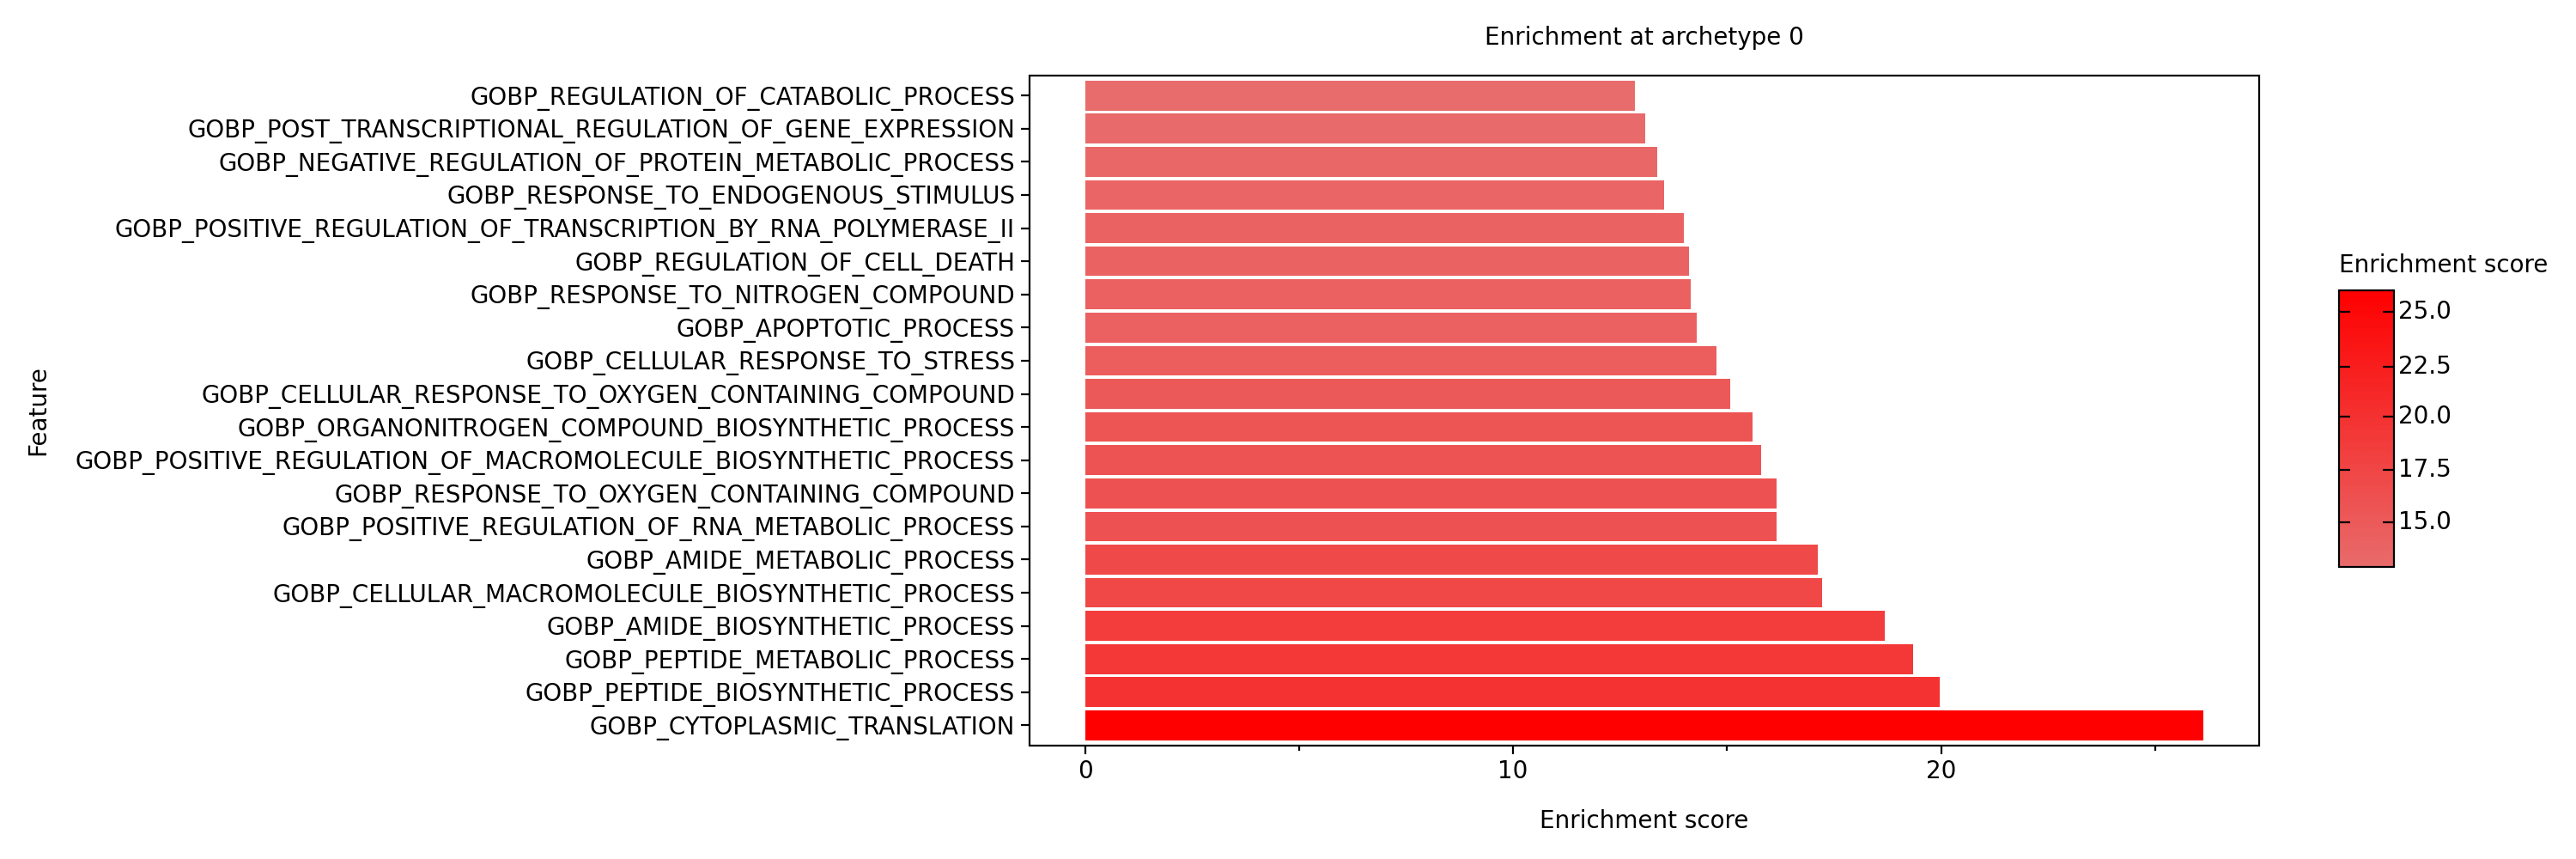

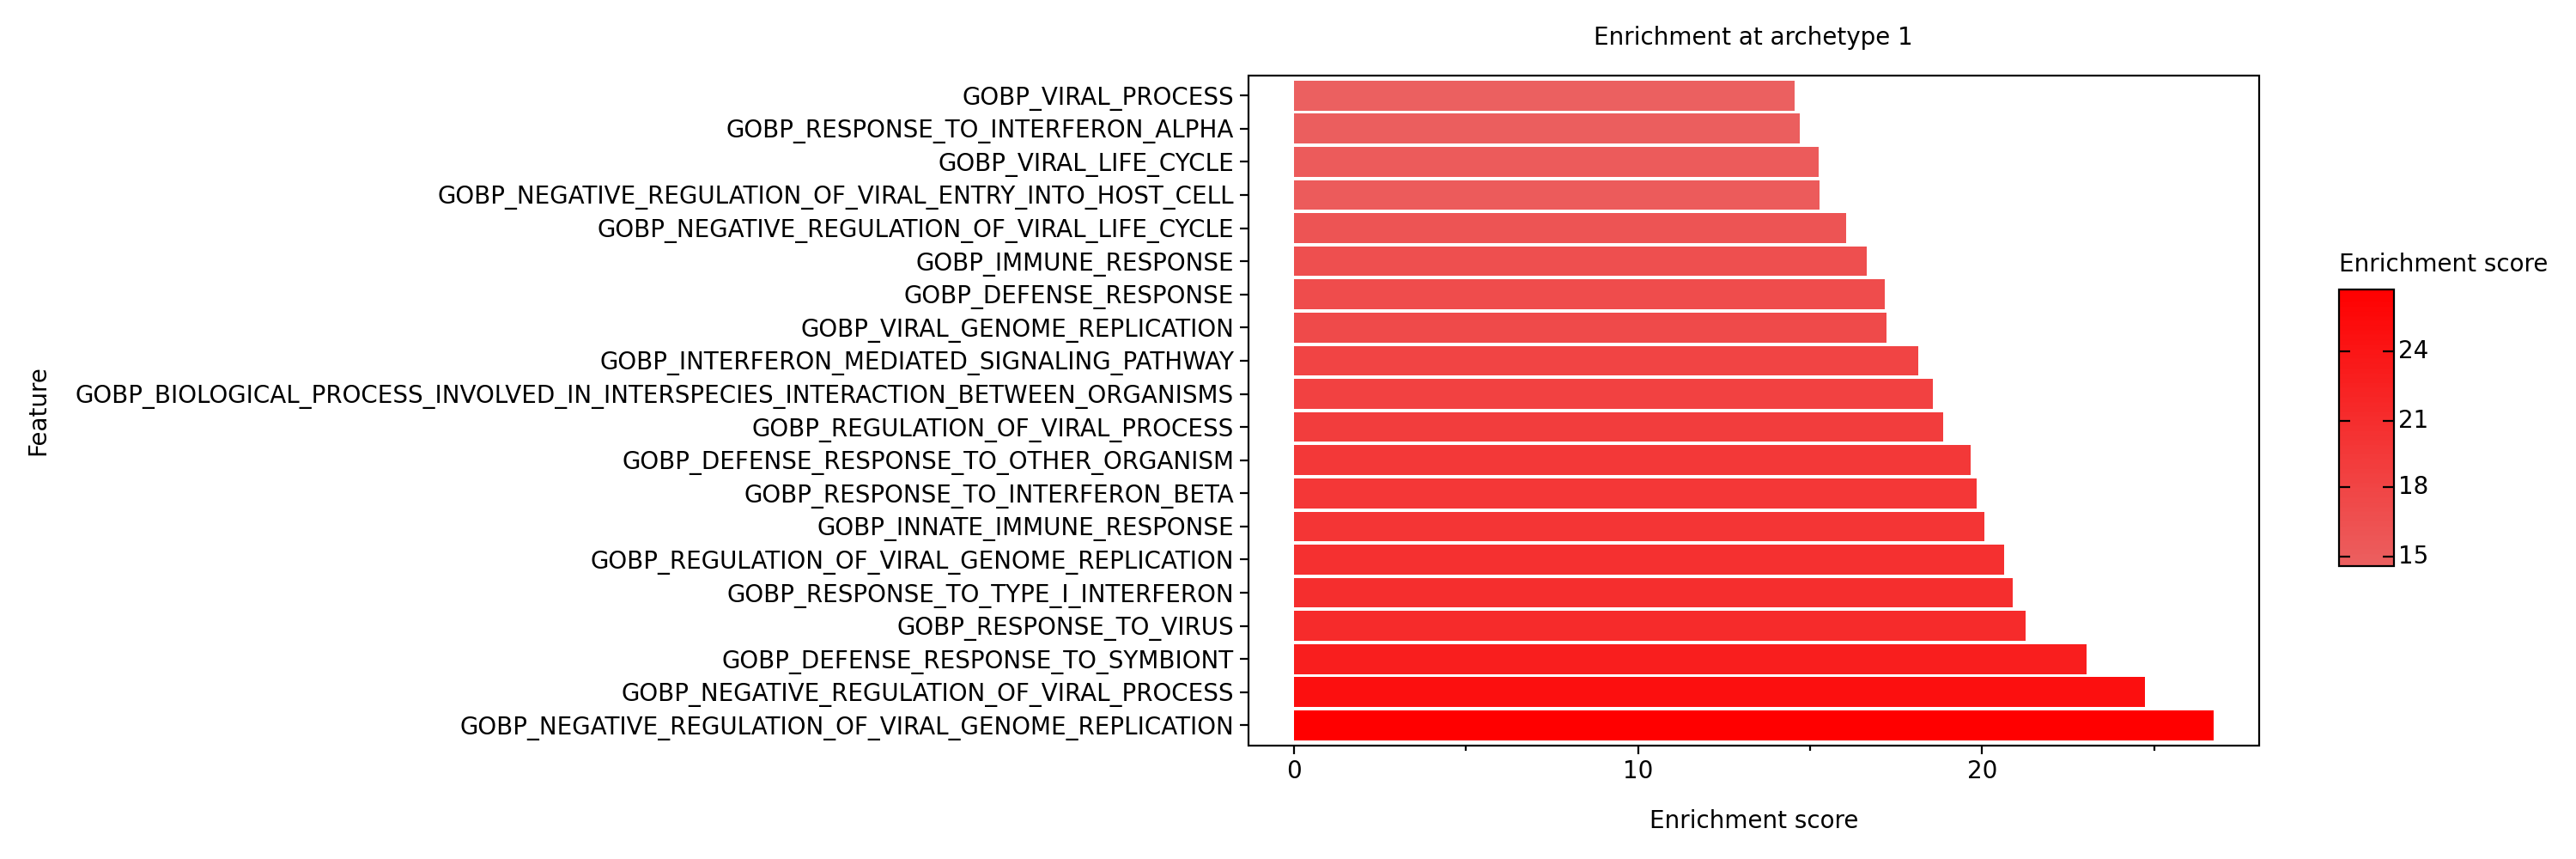

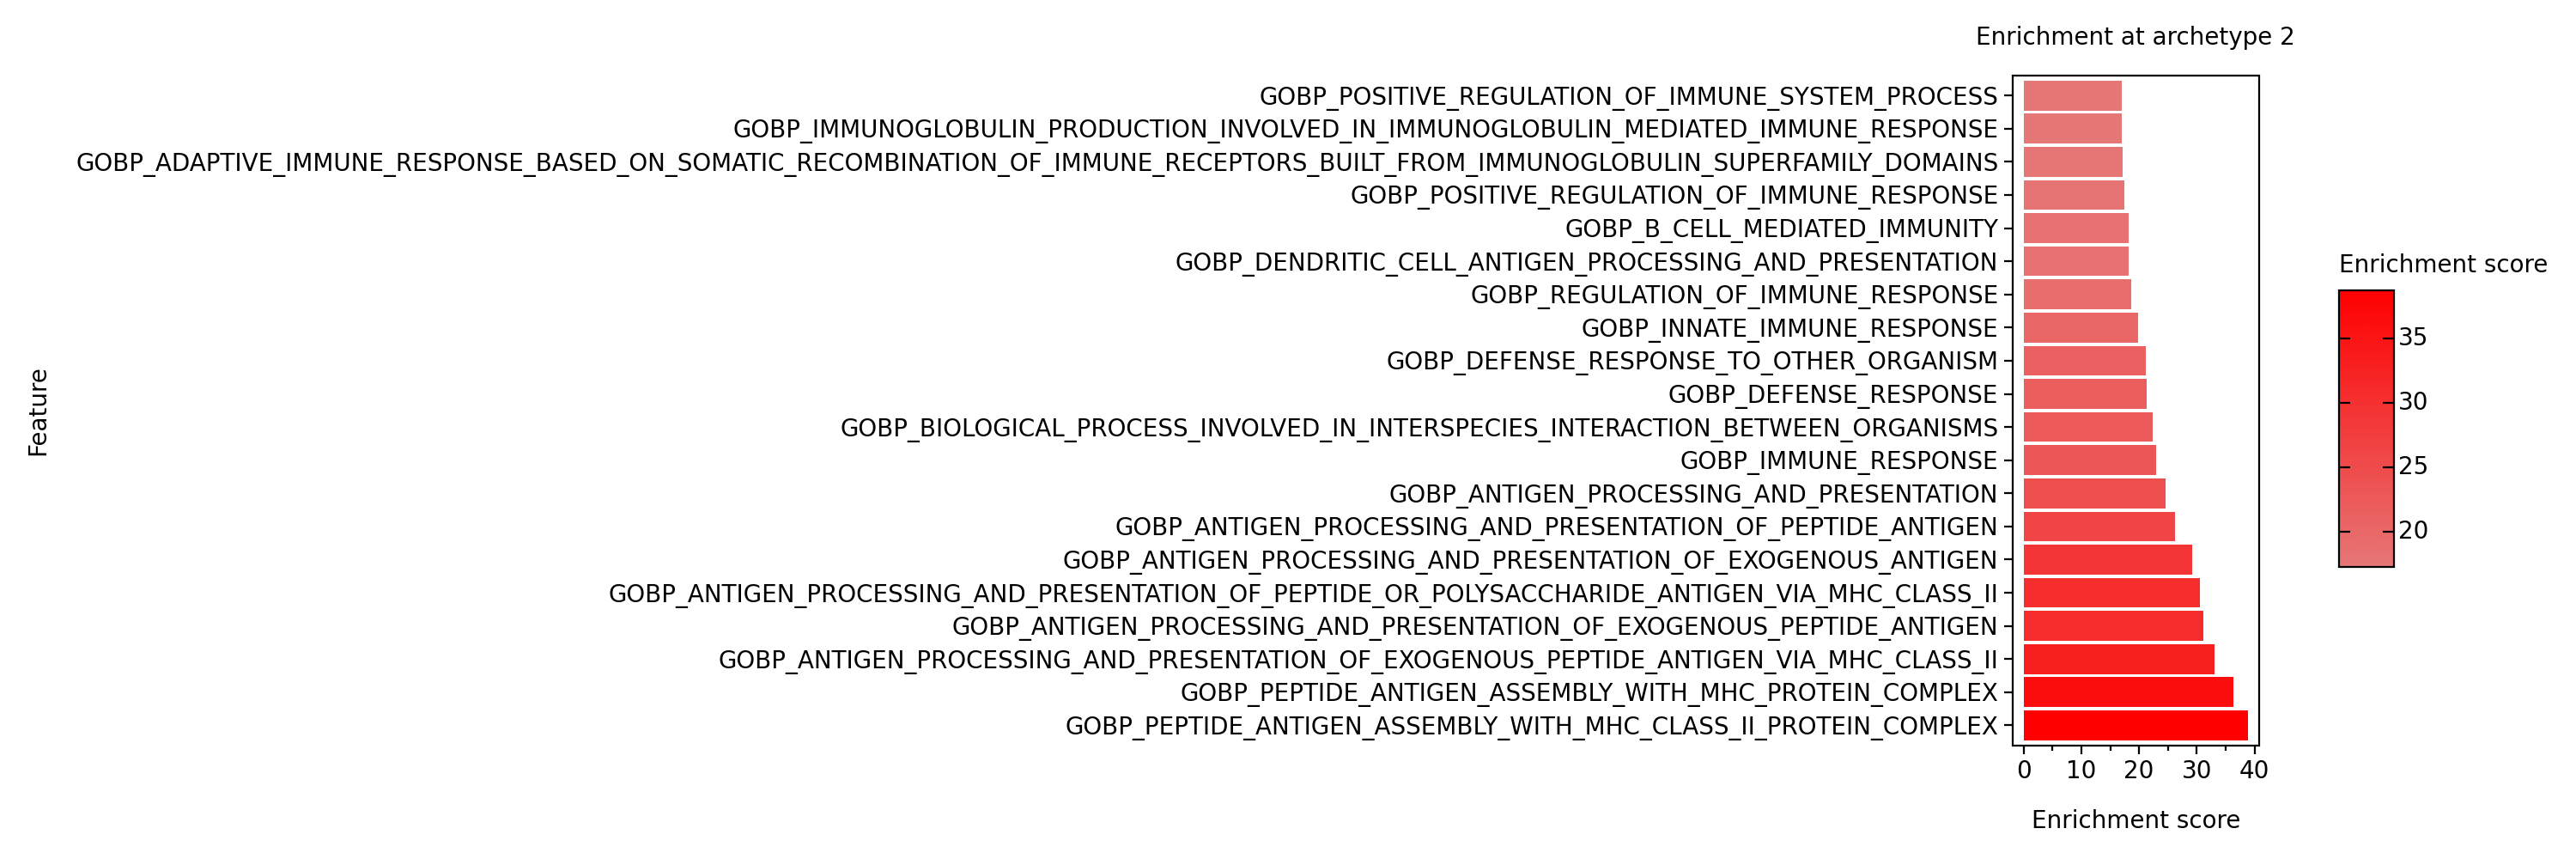

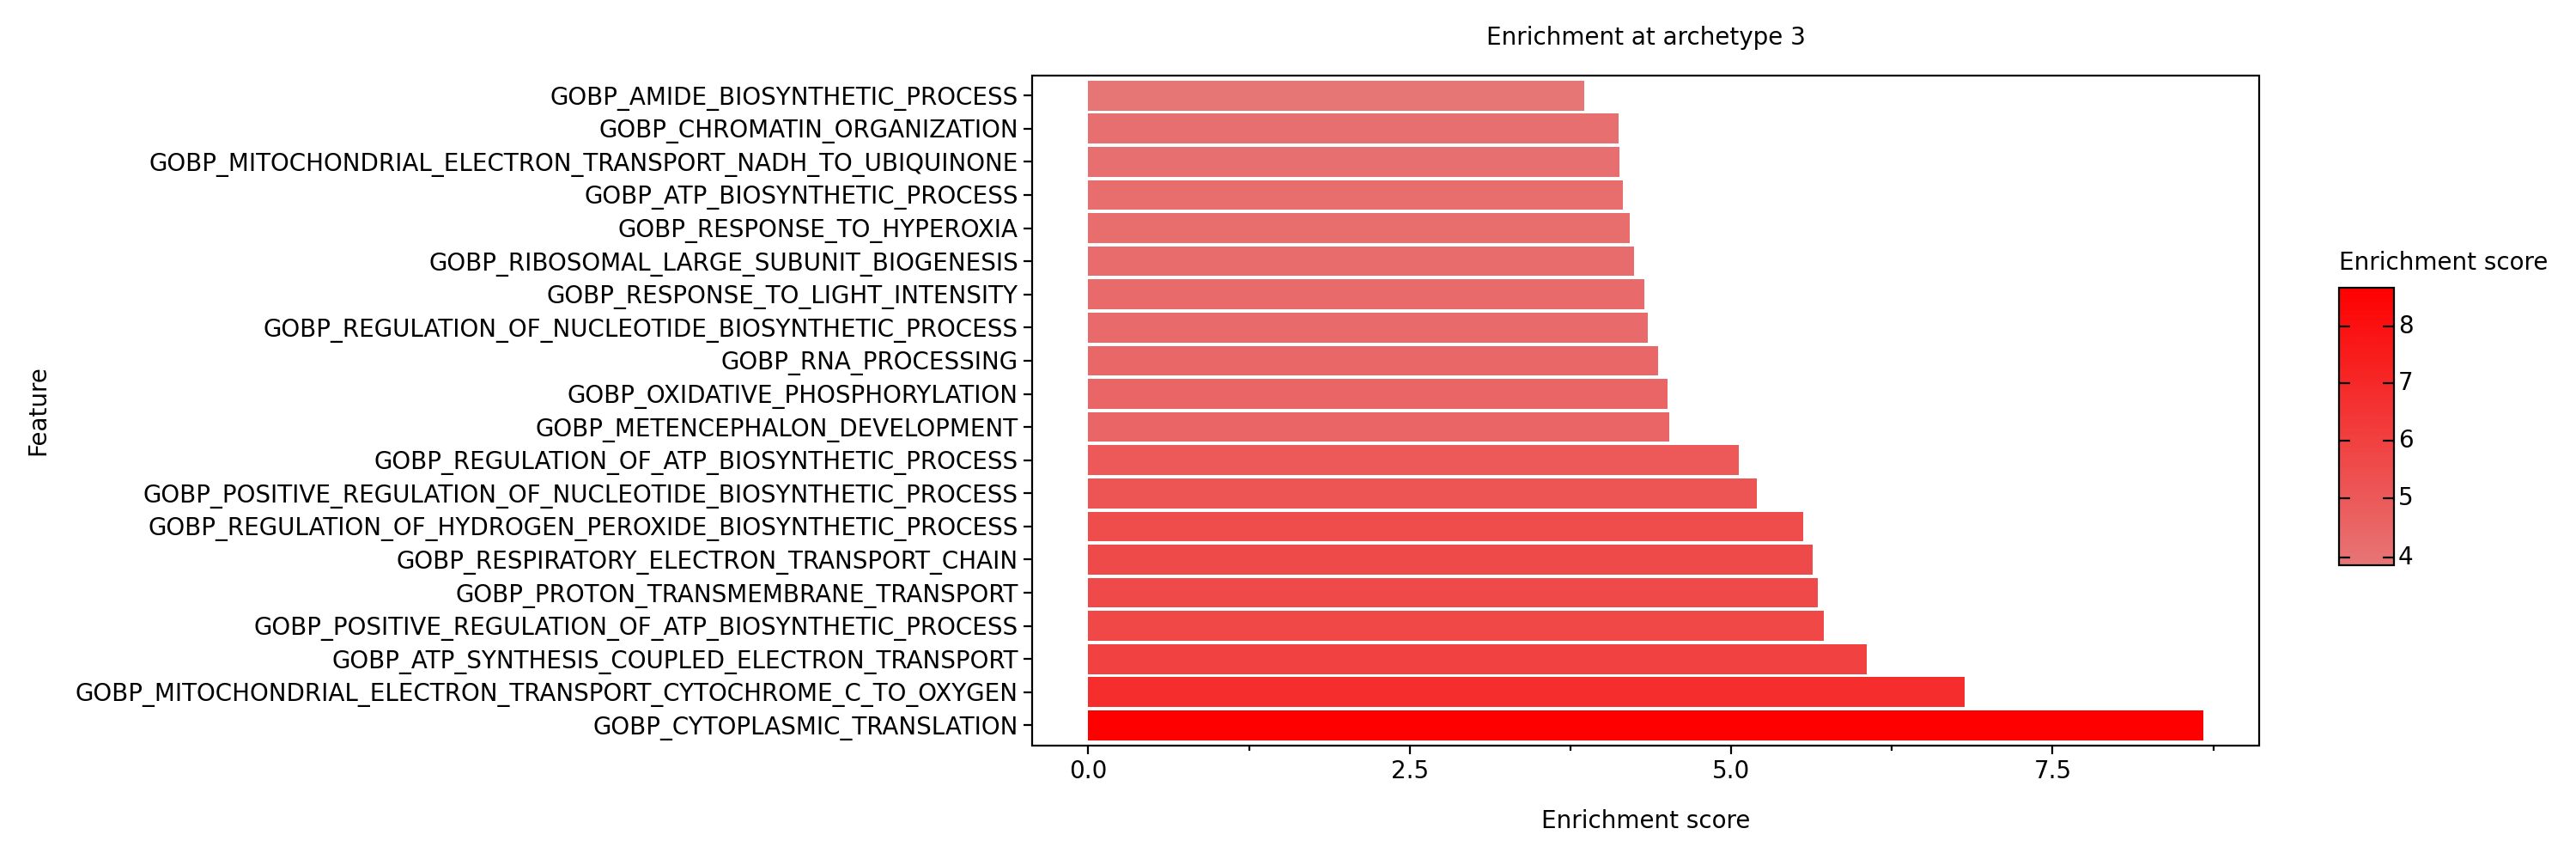

In [46]:
pt.barplot_functional_enrichment(top_processes_msigdb)

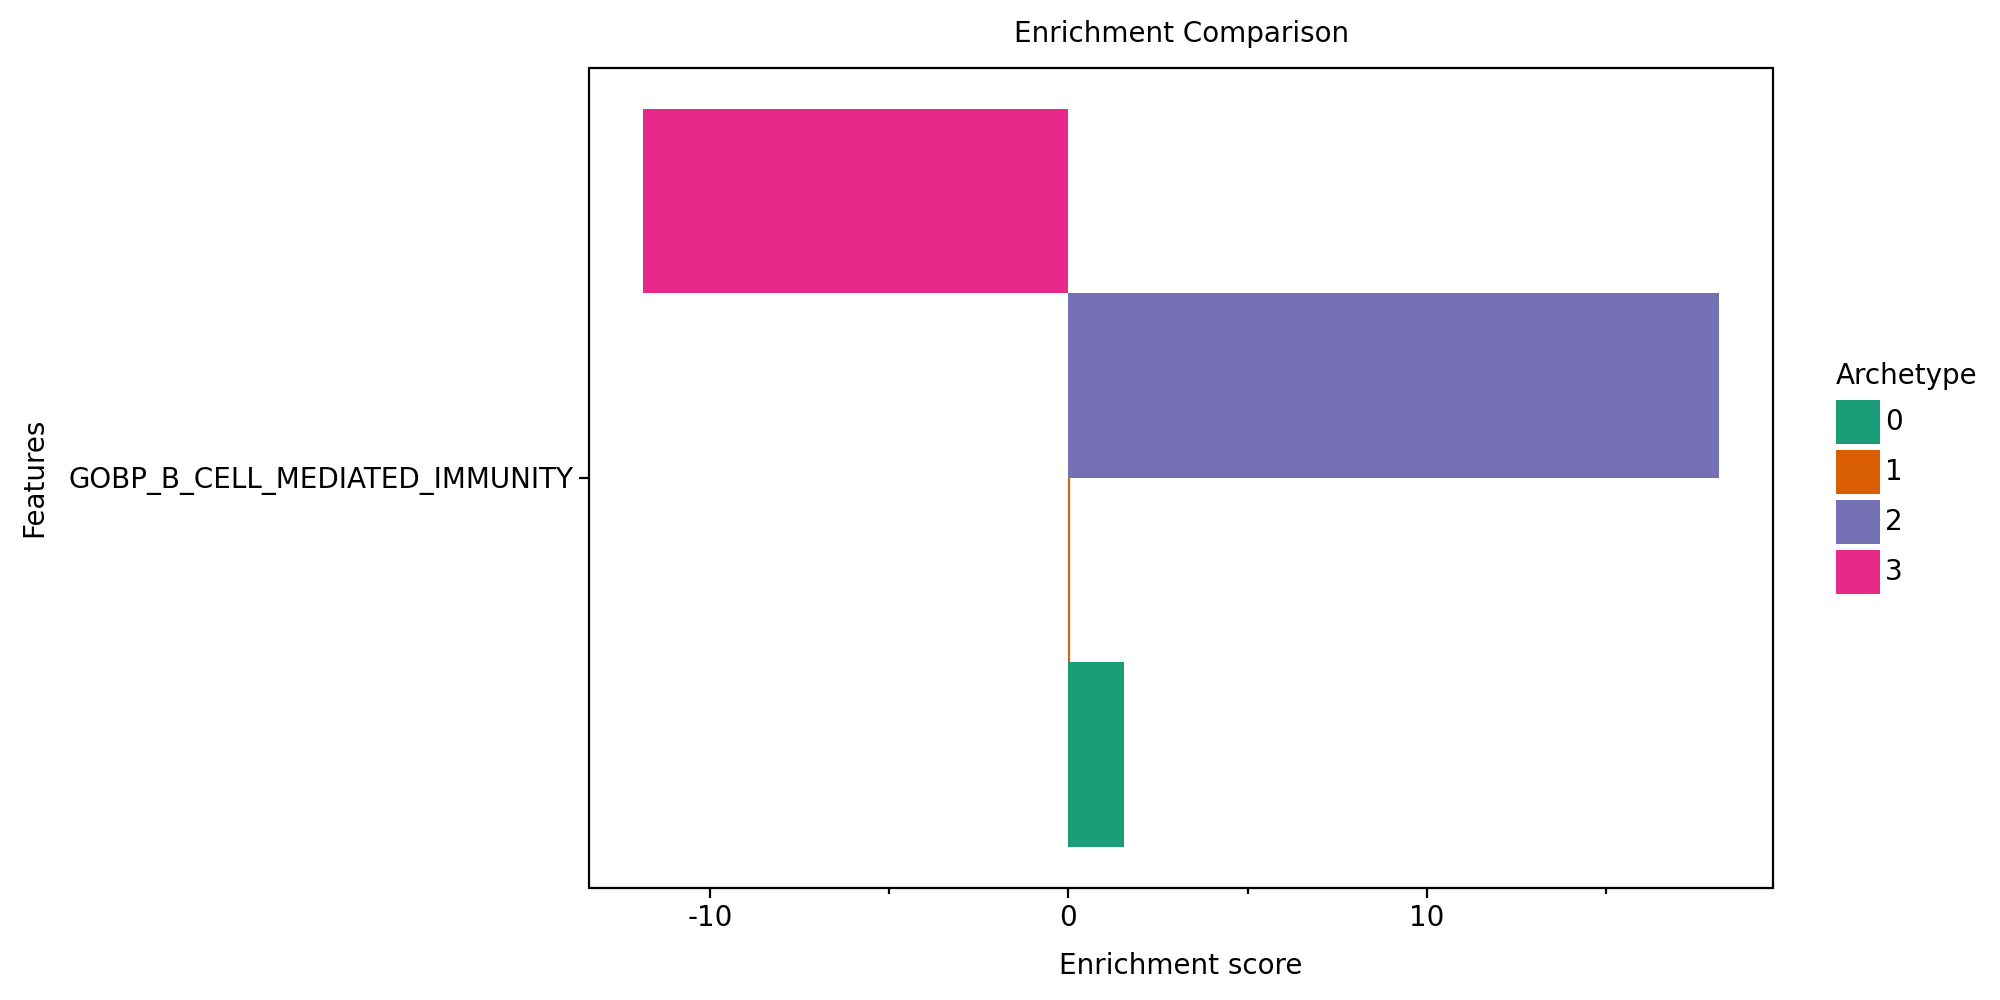

In [47]:
pt.barplot_enrichment_comparison(acts_ulm_est_msigdb, specific_processes_msigdb["archetype_2"].columns)

## Functional Enrichment Cytosig

We will repeat the same process now for other resources:

First access the Cytosig data:

In [48]:
cytosig_url = "https://raw.githubusercontent.com/data2intelligence/CytoSig/master/CytoSig/signature.centroid"
cytosig = pd.read_csv(cytosig_url, sep="\t")
cytosig = cytosig.reset_index().rename(columns={"index": "gene"})
cytosig = cytosig.melt(id_vars=["gene"], var_name="cluster", value_name="expression")
cytosig = cytosig.rename({"cluster": "source", "expression": "weight", "gene": "target"}, axis=1)
cytosig["target-source"] = [t + "-" + s for t, s in zip(cytosig["target"], cytosig["source"])]

Now we run enrichment again with decoupler:

In [49]:
acts_ulm_est_cyt, acts_ulm_est_p_cyt = dc.run_ulm(mat = pseudobulk,
                                                  net = cytosig,
                                                  weight = "weight",
                                                  source='source',
                                                  target='target')

acts_ulm_est_cyt

Activin A      BDNF      BMP2      BMP4      BMP6      CD40L    CXCL12  \
0   2.665553  5.225033  3.564757  1.121489 -6.361289  15.458454  8.815626   
1   1.480394  5.221160  3.709872  3.657784 -5.008379  -6.286318 -0.177543   
2   0.037463  1.728255  2.241406  2.448992 -7.159456  -3.895906  1.710061   
3  -4.764919 -4.782564 -3.973836 -8.314707  5.963428  -7.822813 -9.273580   

         EGF      FGF2      GCSF  ...      MCSF         NO        OSM  \
0  15.049659  6.312557  5.081458  ... -2.806674  11.101003   8.712006   
1   2.267763  0.503610  0.353394  ... -3.554798  -3.973433  10.325349   
2   1.618446  2.733133 -2.584031  ...  2.670668  -6.567106  12.121427   
3  -3.880505 -8.154499 -7.116293  ... -9.820260  -7.872505 -16.116859   

      TGFB1     TGFB3       TNFA      TRAIL      TWEAK      VEGFA     WNT3A  
0  1.700836  8.732059  19.040577  17.209229  15.015483  14.282654 -4.730549  
1 -6.556732 -8.214877   2.710394  -1.772144   0.503282  -3.161930 -2.813391  
2 -6.963931 -7.346761   4.183075   0.700535   5.526673  -2.460073 -5.240769  
3 -0.076623 -1.652767 -17.063276  -7.469678  -9.776951  -3.759138  3.640366  

[4 rows x 43 columns]

Extract top processes:

In [50]:
top_processes_cyt = pt.extract_enriched_processes(est=acts_ulm_est_cyt, 
                                                  pval=acts_ulm_est_p_cyt, 
                                                  order="desc", 
                                                  n=20, 
                                                  p_threshold=0.05)

In [51]:
specific_processes_cyt = pt.extract_specific_processes(est=acts_ulm_est_cyt, 
                                                       pval=acts_ulm_est_p_cyt, 
                                                       drop_threshold = 2,
                                                       n=10, 
                                                       p_threshold=0.05)

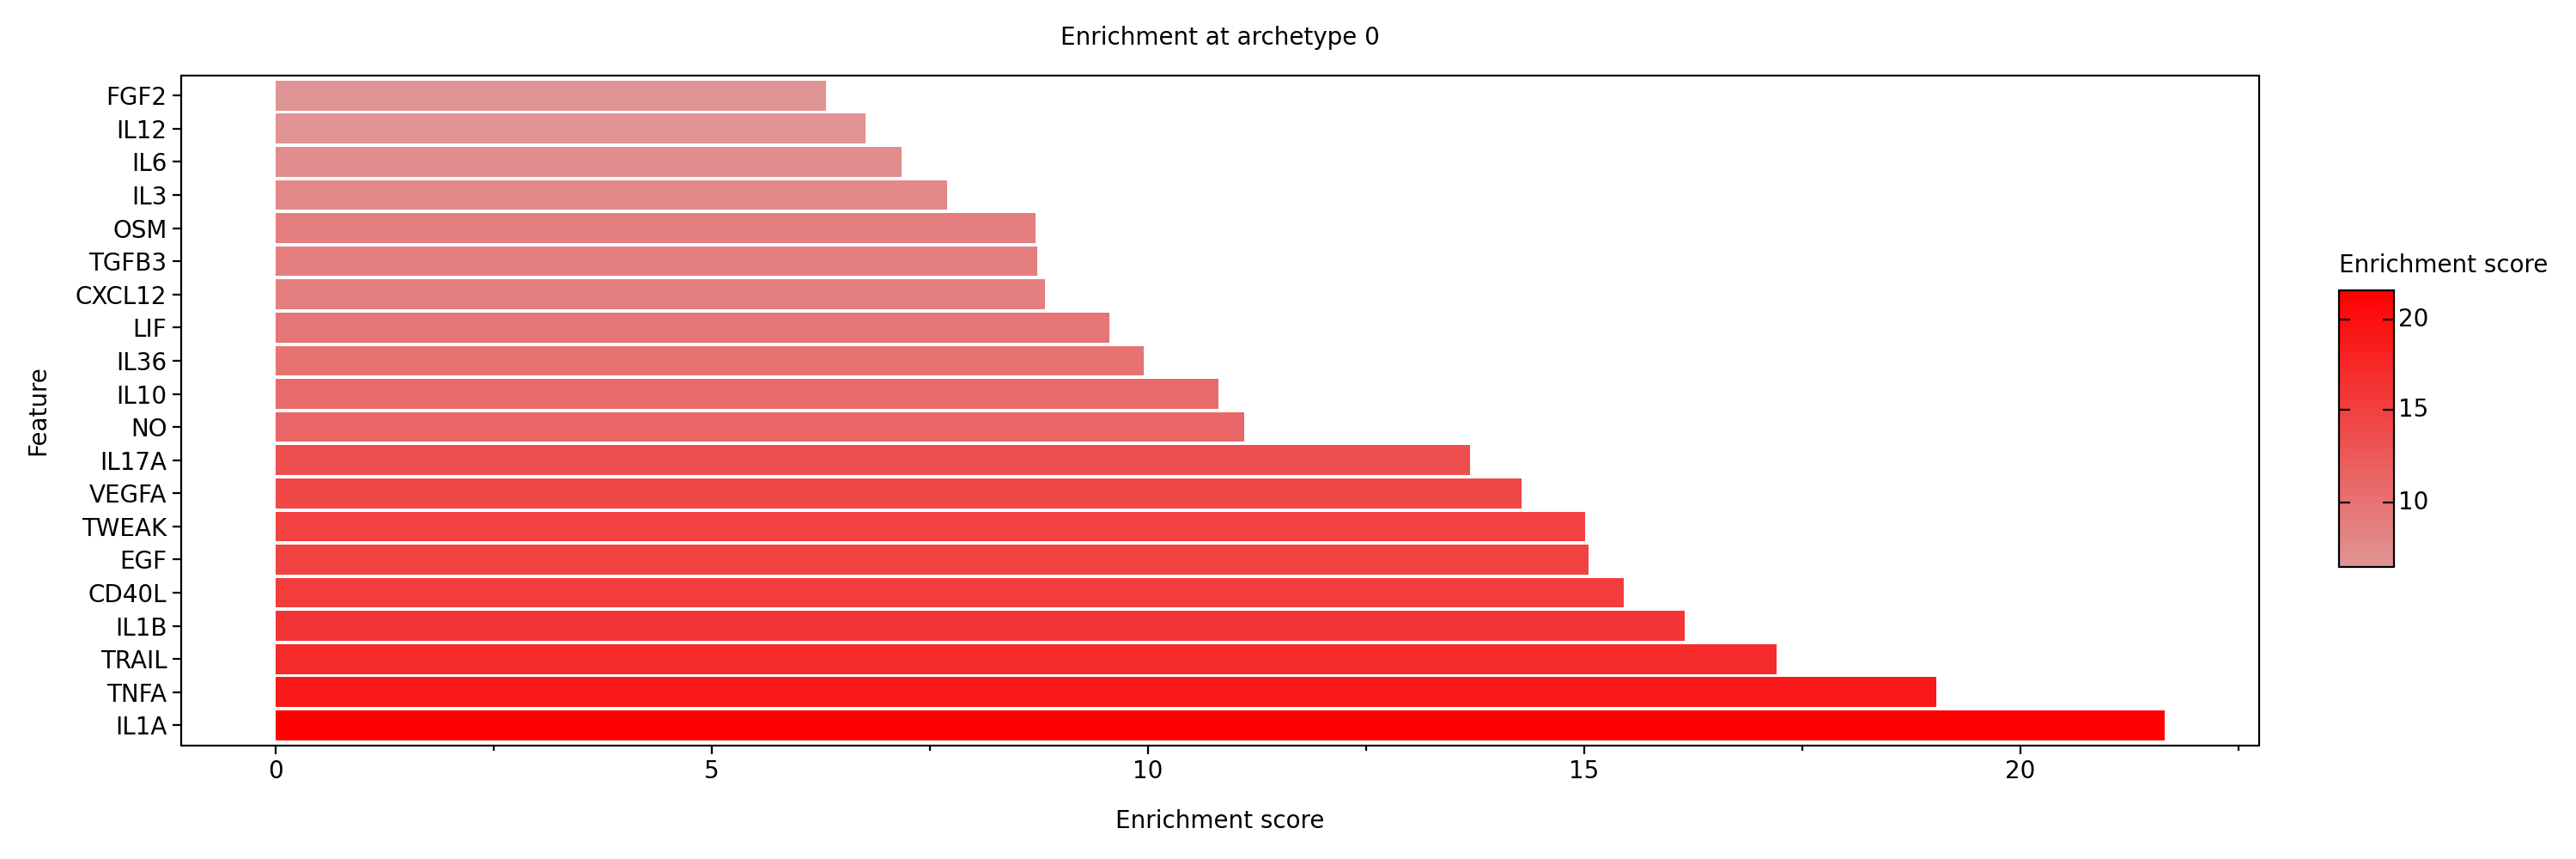

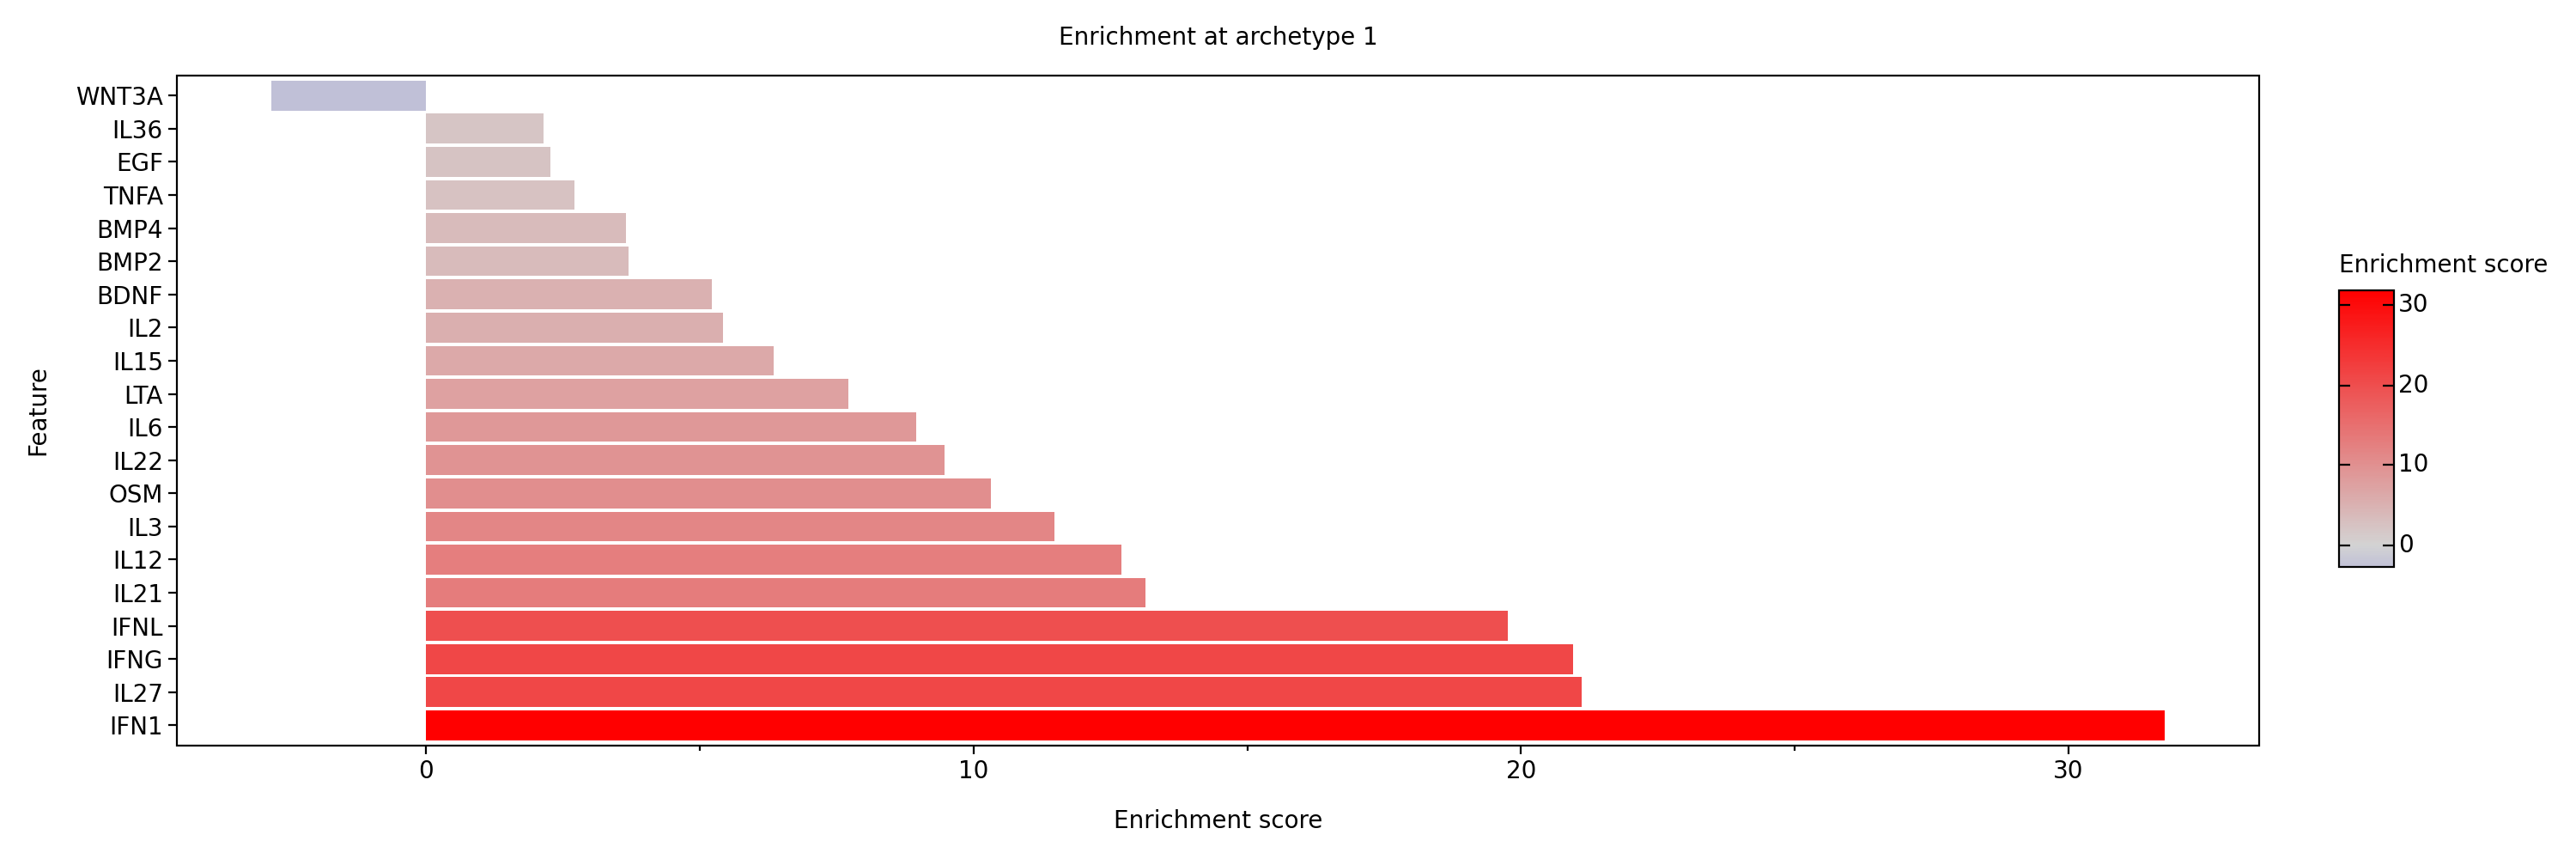

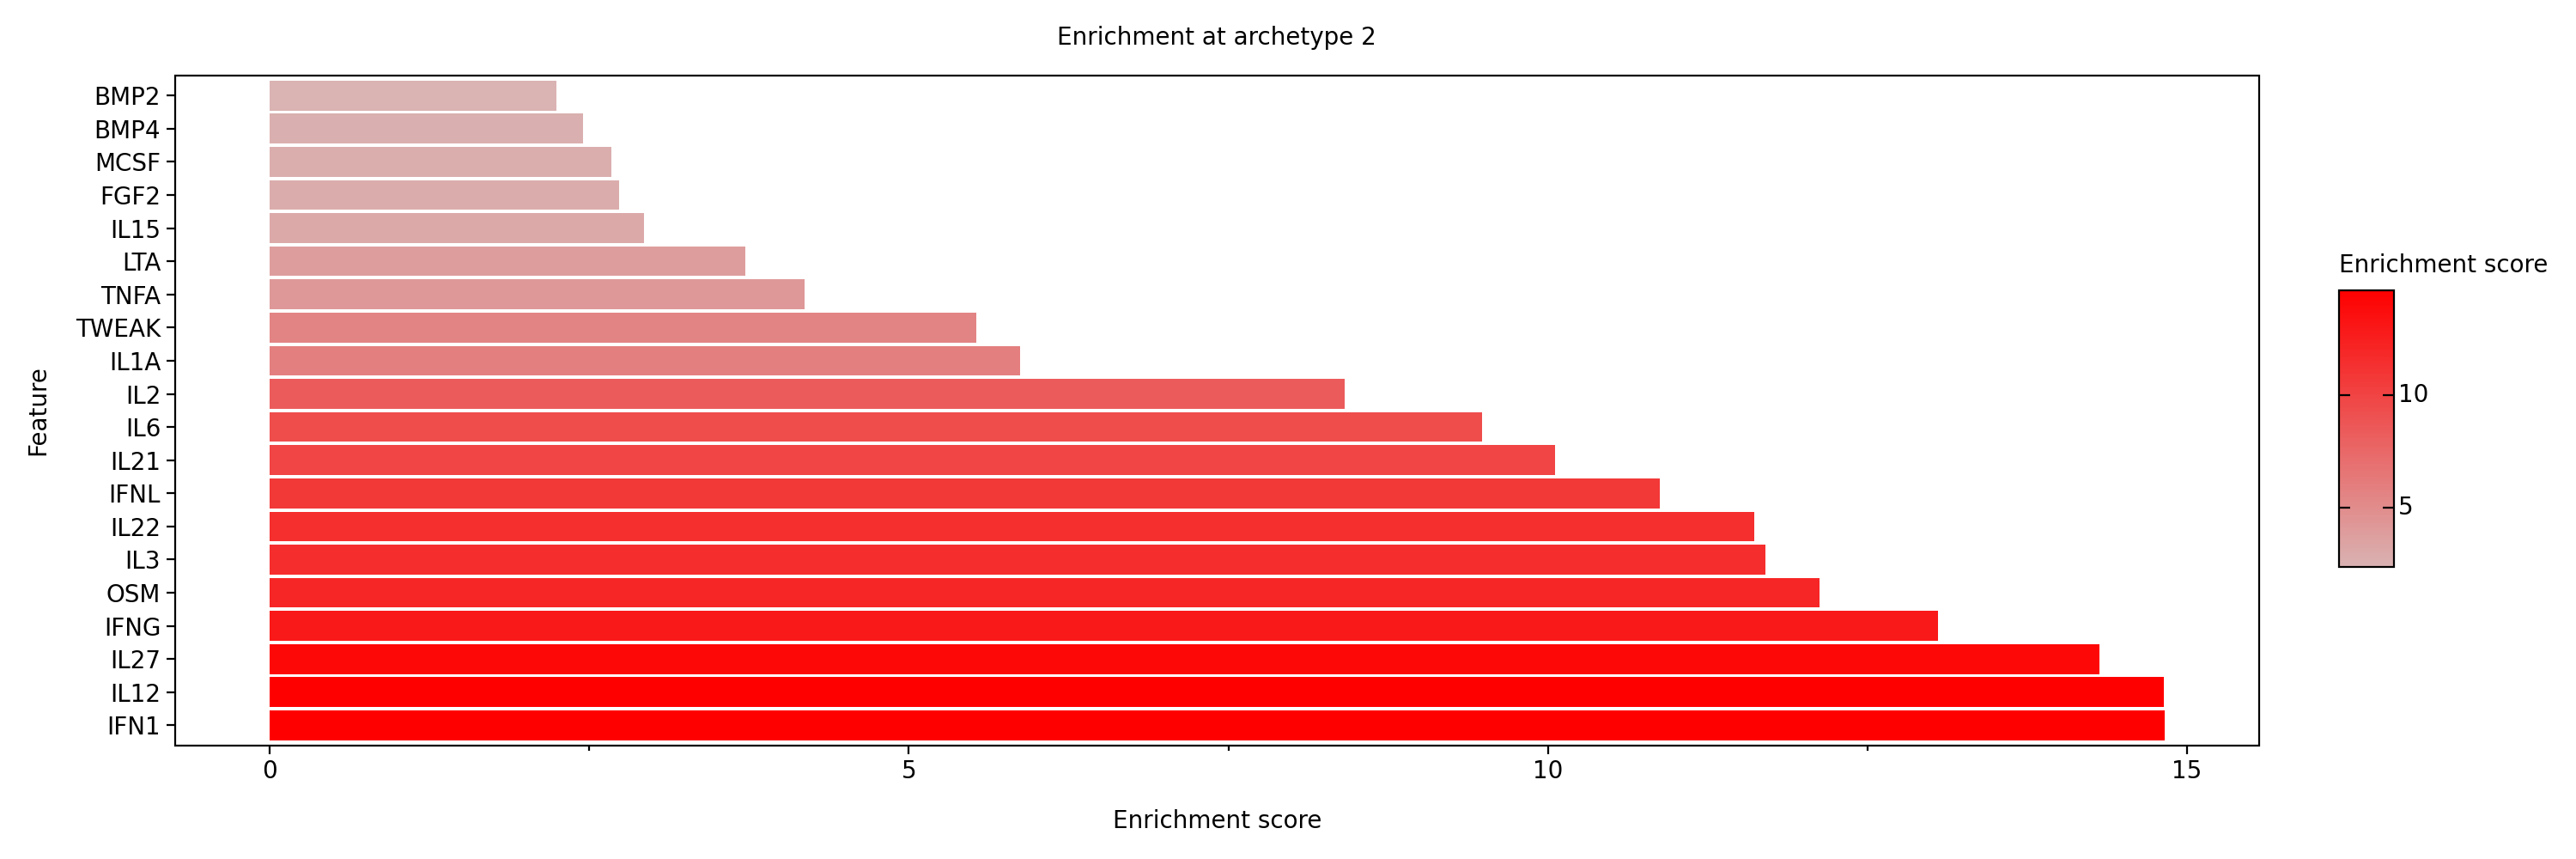

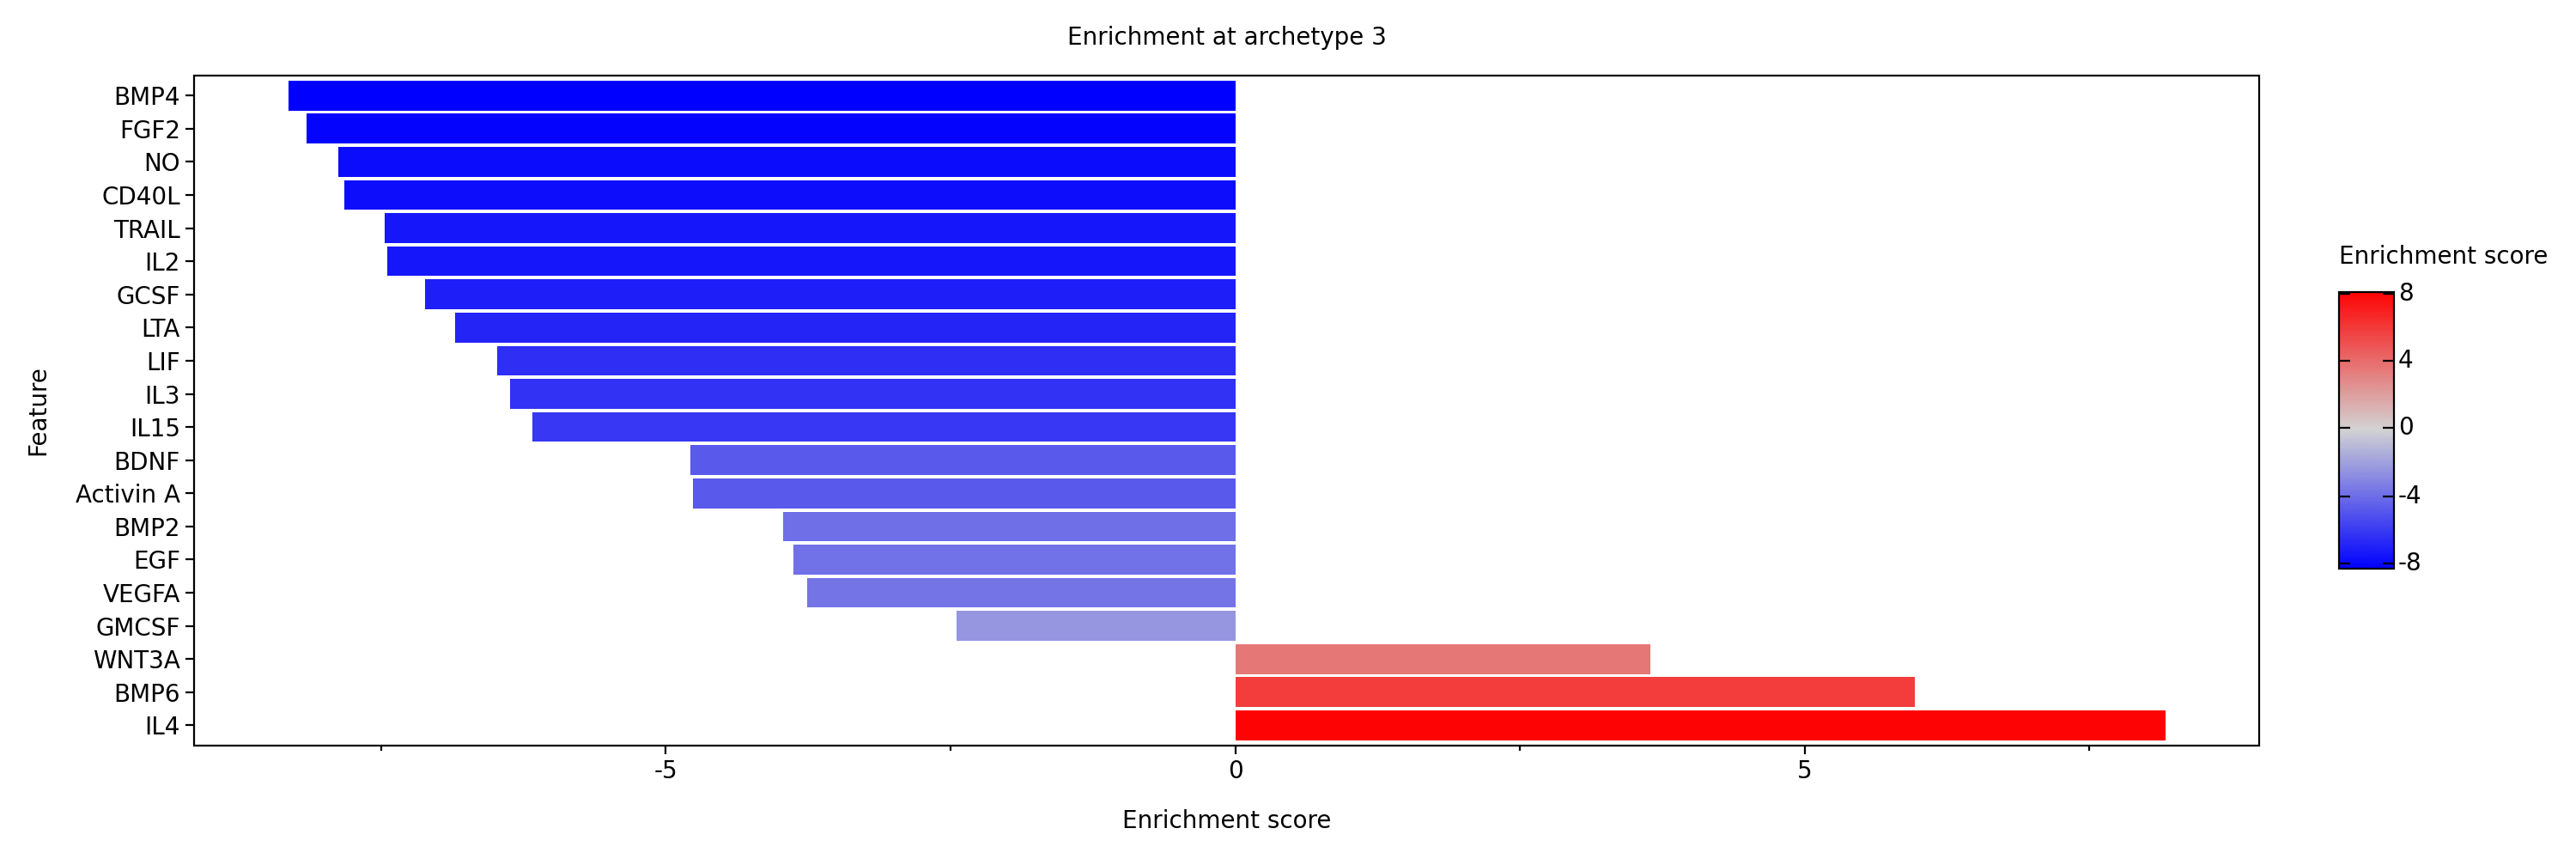

In [52]:
pt.barplot_functional_enrichment(top_processes_cyt)

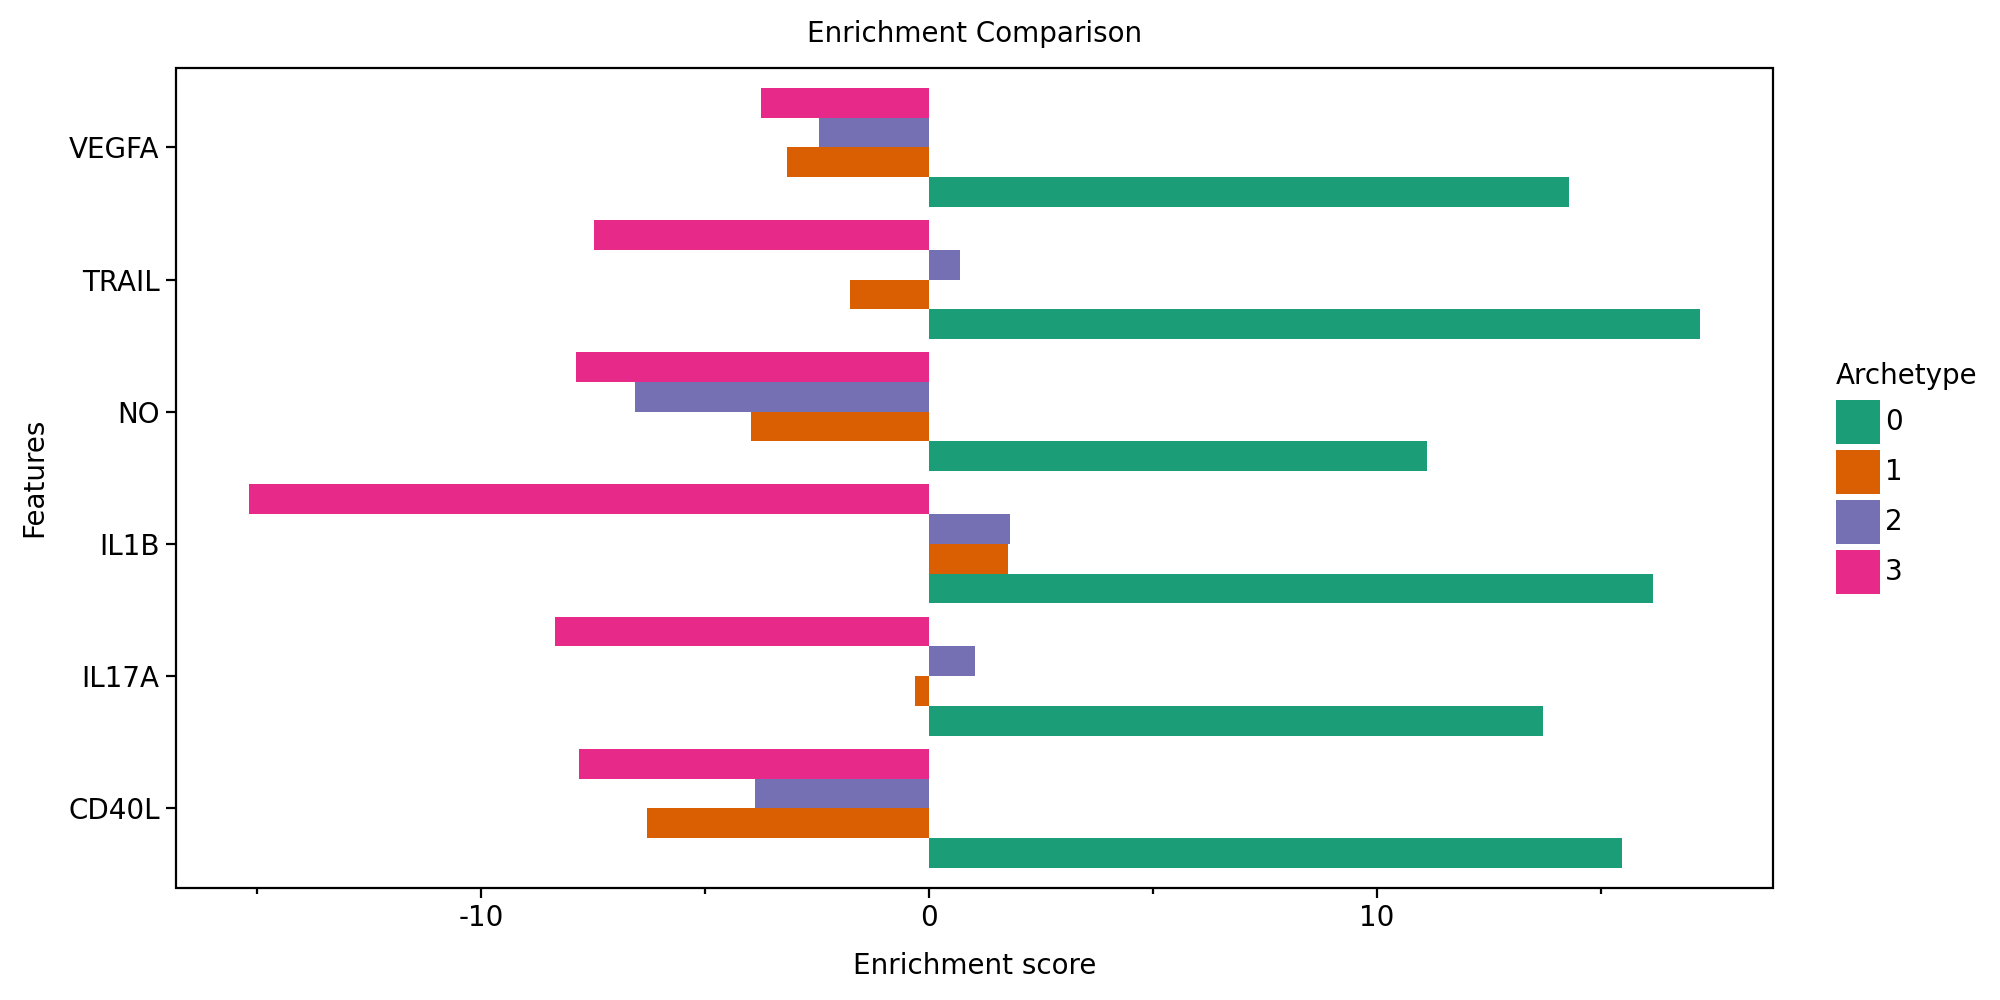

In [53]:
pt.barplot_enrichment_comparison(acts_ulm_est_cyt, specific_processes_cyt["archetype_0"].columns)

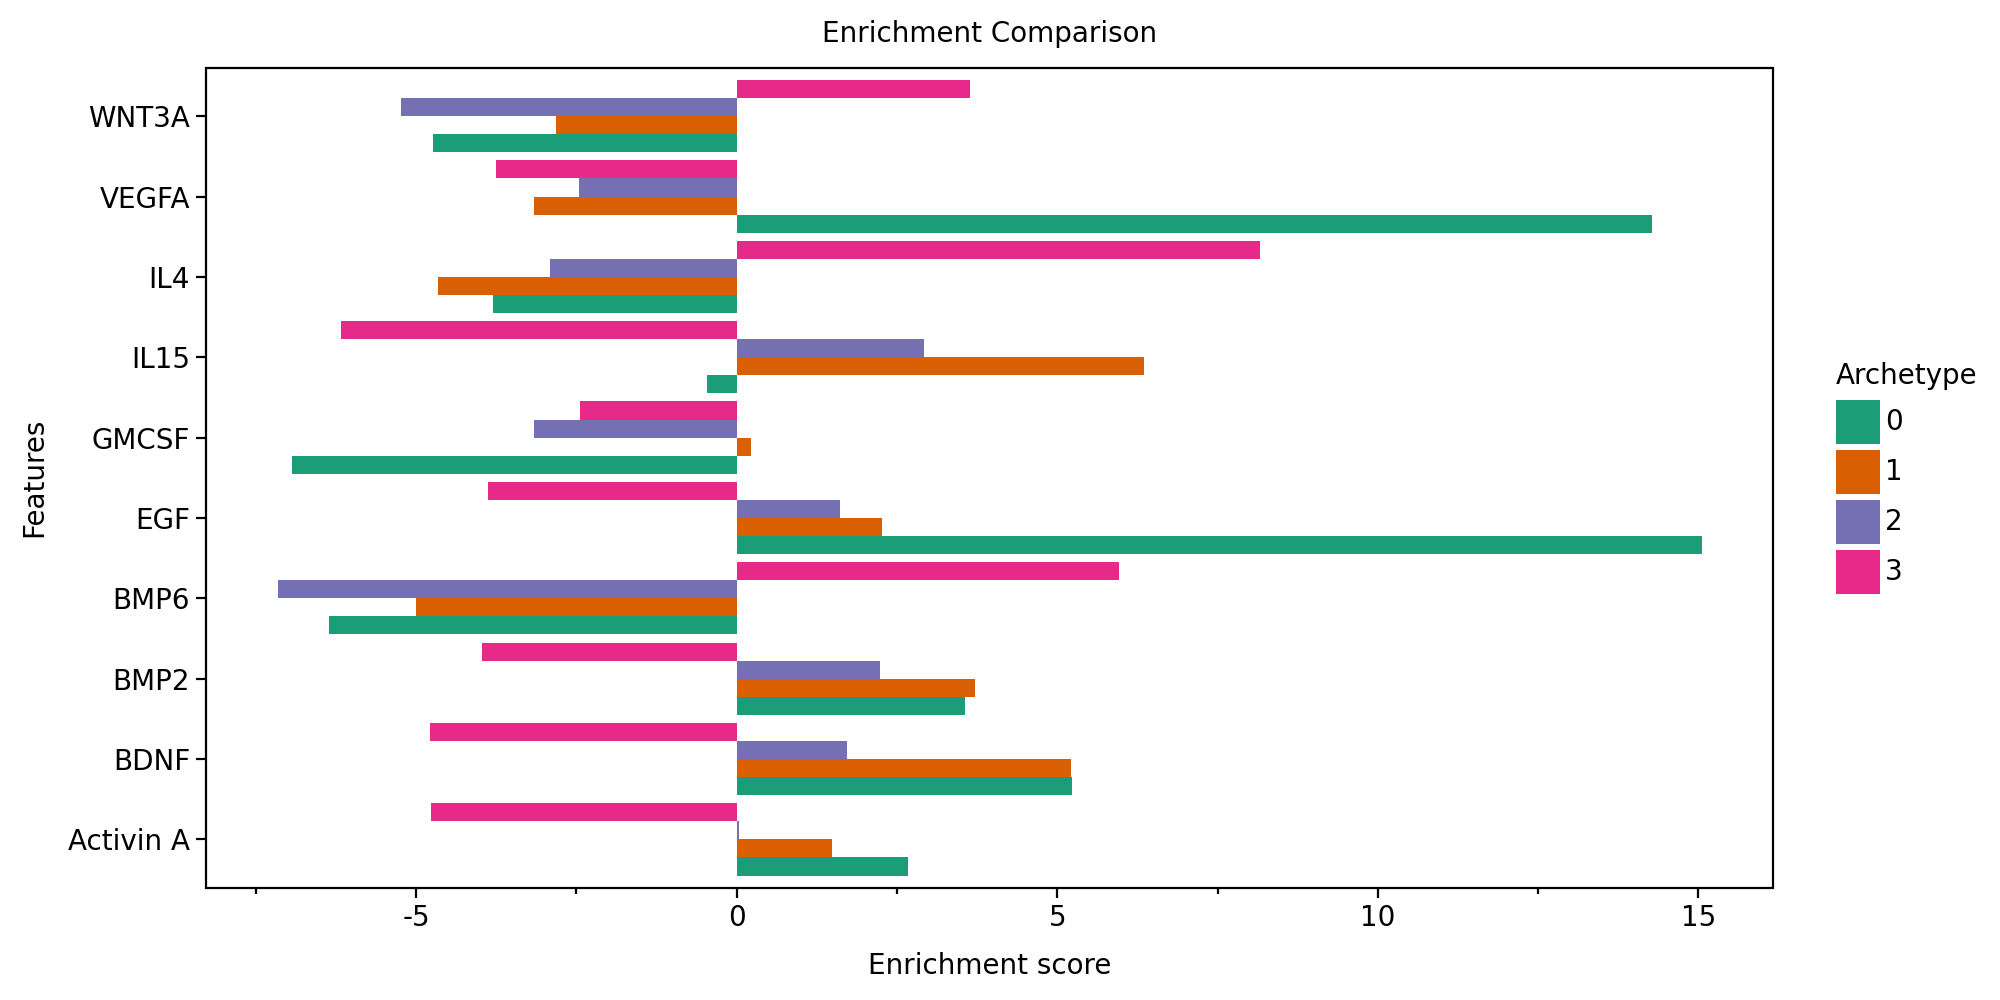

In [54]:
pt.barplot_enrichment_comparison(acts_ulm_est_cyt, top_processes_cyt["archetype_3"]["Process"][:10])

## Functional Enrichment CollecTri

Get resource:

In [55]:
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

source  target  weight
0       ABL1     BAX       1
1       ABL1    BCL2      -1
2       ABL1    BCL6      -1
3       ABL1   CCND2       1
4       ABL1  CDKN1A       1
...      ...     ...     ...
40625   ZXDC  CDKN1C       1
40626   ZXDC  CDKN2A       1
40627   ZXDC   CIITA       1
40628   ZXDC   HLA-E       1
40629   ZXDC     IL5       1

[40630 rows x 3 columns]

Estimate enrichment:

In [56]:
acts_ulm_est_collectri, acts_ulm_est_p_collectri = dc.run_ulm(mat = pseudobulk,
                                                              net = collectri,
                                                              weight = "weight",
                                                              source='source',
                                                              target='target')

acts_ulm_est_collectri

ABL1       AHR       AIP       AIRE        AP1     APEX1        AR  \
0  3.413639  6.543821 -0.646860  12.017322  10.670175  3.967757  7.129731   
1  2.596853  1.578192  0.182986  -1.741146   4.766723  0.530517  1.872569   
2  1.939676  3.770180  0.148061  -0.120467   7.111629  0.604274  2.626277   
3 -4.115745 -6.222464  0.001737  -4.647528  -9.595231 -1.966731 -2.755236   

     ARID1A    ARID1B    ARID3A  ...    ZNF382    ZNF384    ZNF395    ZNF410  \
0  1.271083 -0.190981  0.205105  ... -3.961654  2.852588 -2.288700  1.201987   
1  1.453306 -0.179762  2.173767  ...  0.810212 -0.783090  5.196341  0.003863   
2  0.468474 -0.674349  0.382123  ... -1.826721 -1.463351  1.767983  0.287472   
3 -2.064051 -0.083566 -2.179395  ...  1.717635  0.360857 -2.972269  0.197099   

     ZNF436    ZNF699     ZNF76   ZNF804A     ZNF91      ZXDC  
0  1.389374  1.510906 -0.233665  2.242401  4.560277  1.422257  
1  0.452017 -0.368212 -0.746232  0.208846  2.116634  1.883522  
2  0.571513 -0.392797 -0.487981 -1.468526  1.408587 -2.306342  
3 -0.608399  0.382882  2.593130  0.464820 -3.205230  0.228972  

[4 rows x 636 columns]

Extract top scores:

In [57]:
top_processes_collectri = pt.extract_enriched_processes(est=acts_ulm_est_collectri, 
                                                        pval=acts_ulm_est_p_collectri, 
                                                        order="desc", 
                                                        n=20, 
                                                        p_threshold=0.05)

In [58]:
specific_processes_collectri = pt.extract_specific_processes(est=acts_ulm_est_collectri, 
                                                             pval=acts_ulm_est_p_collectri, 
                                                             drop_threshold = 2,
                                                             n=20, 
                                                             p_threshold=0.05)

Plot results:

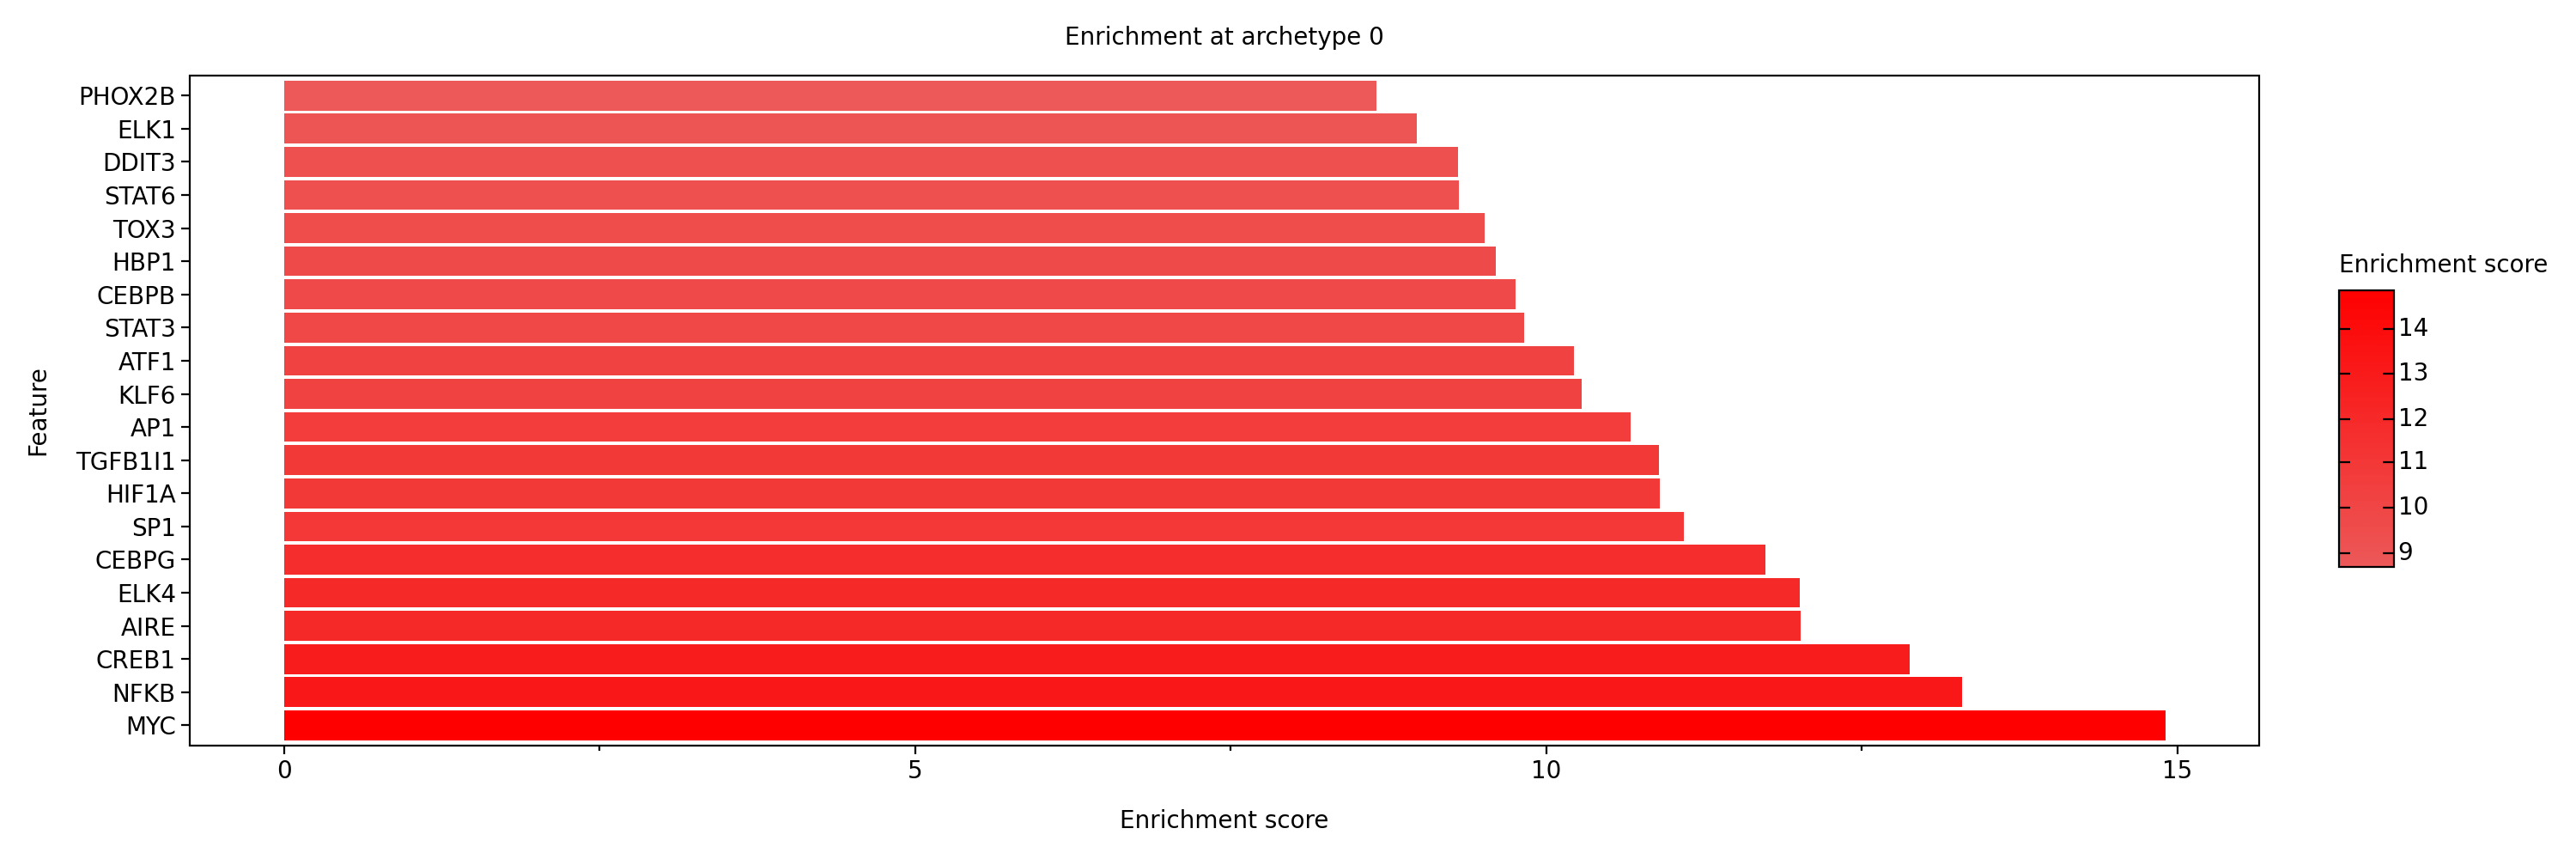

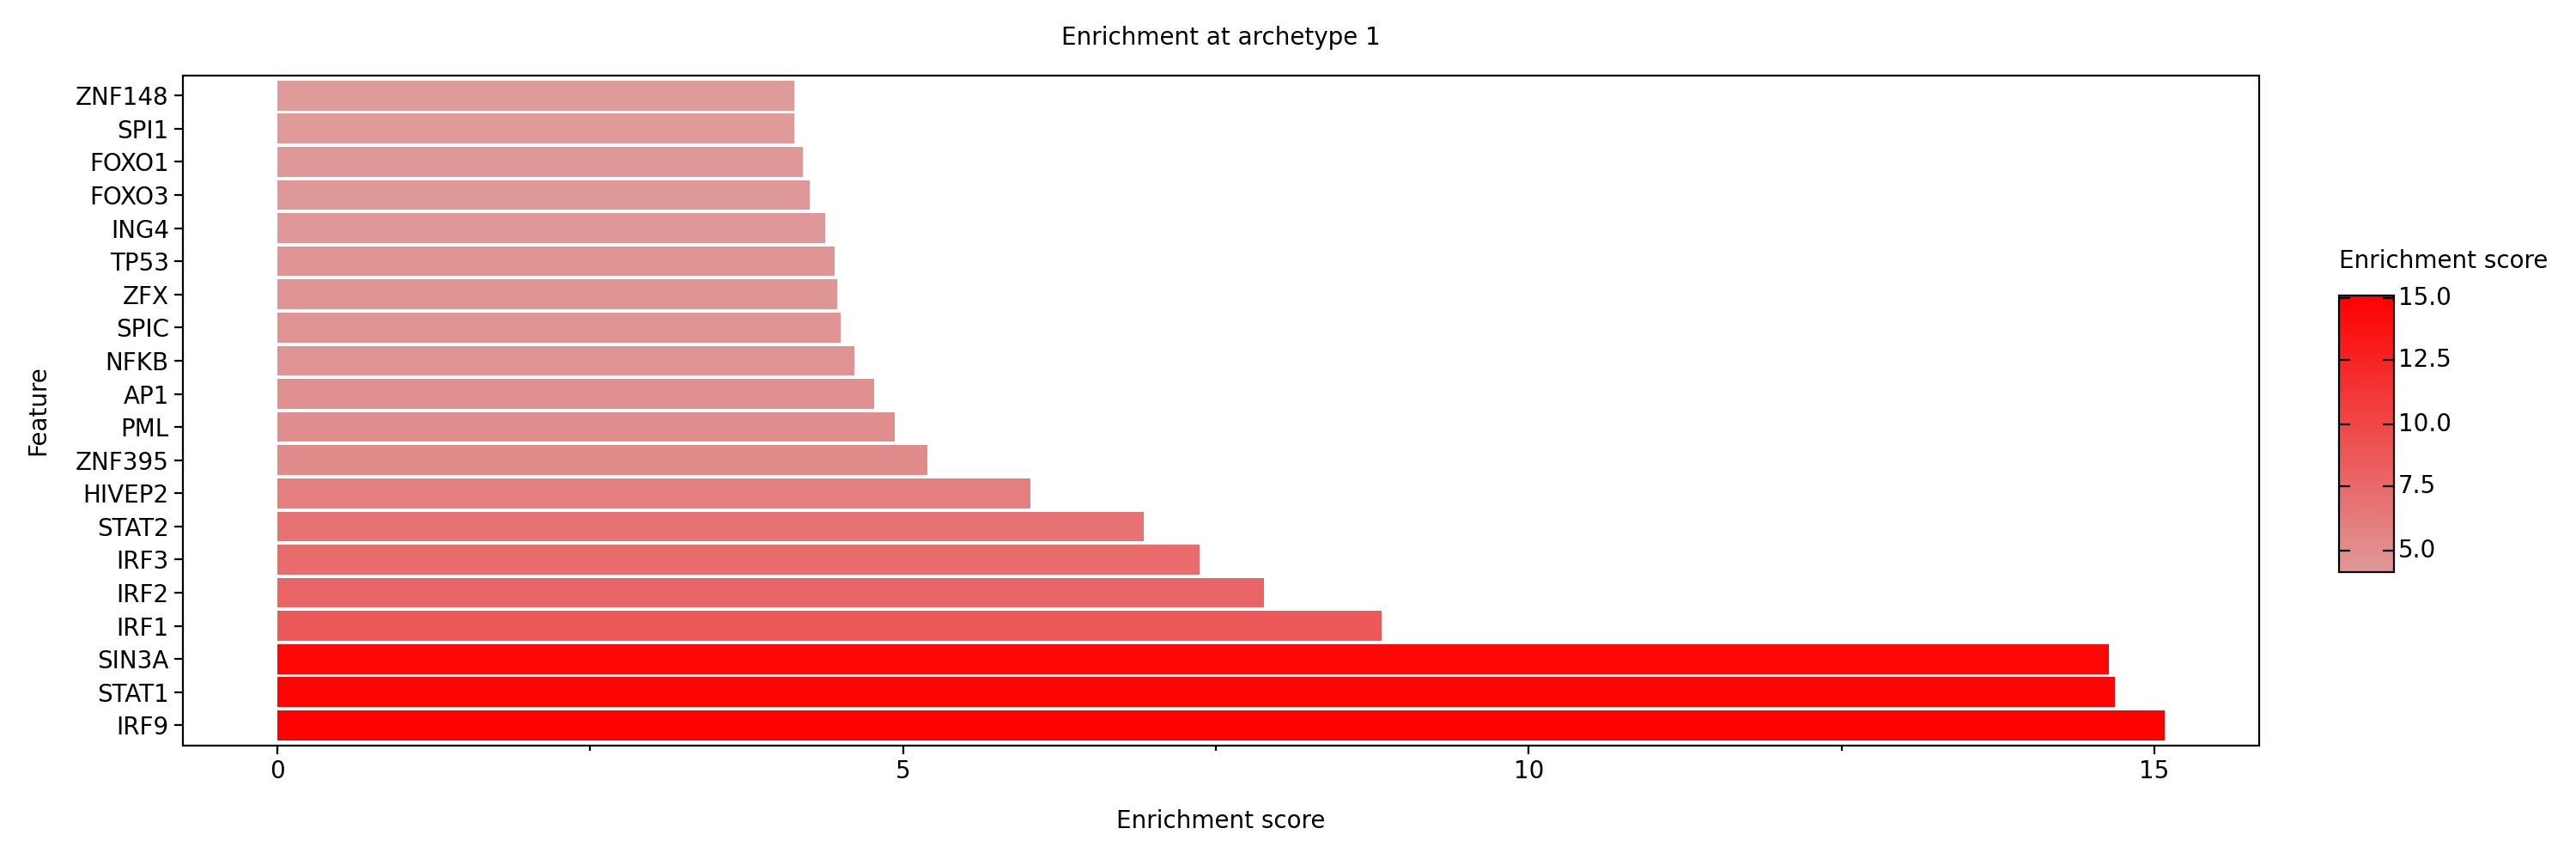

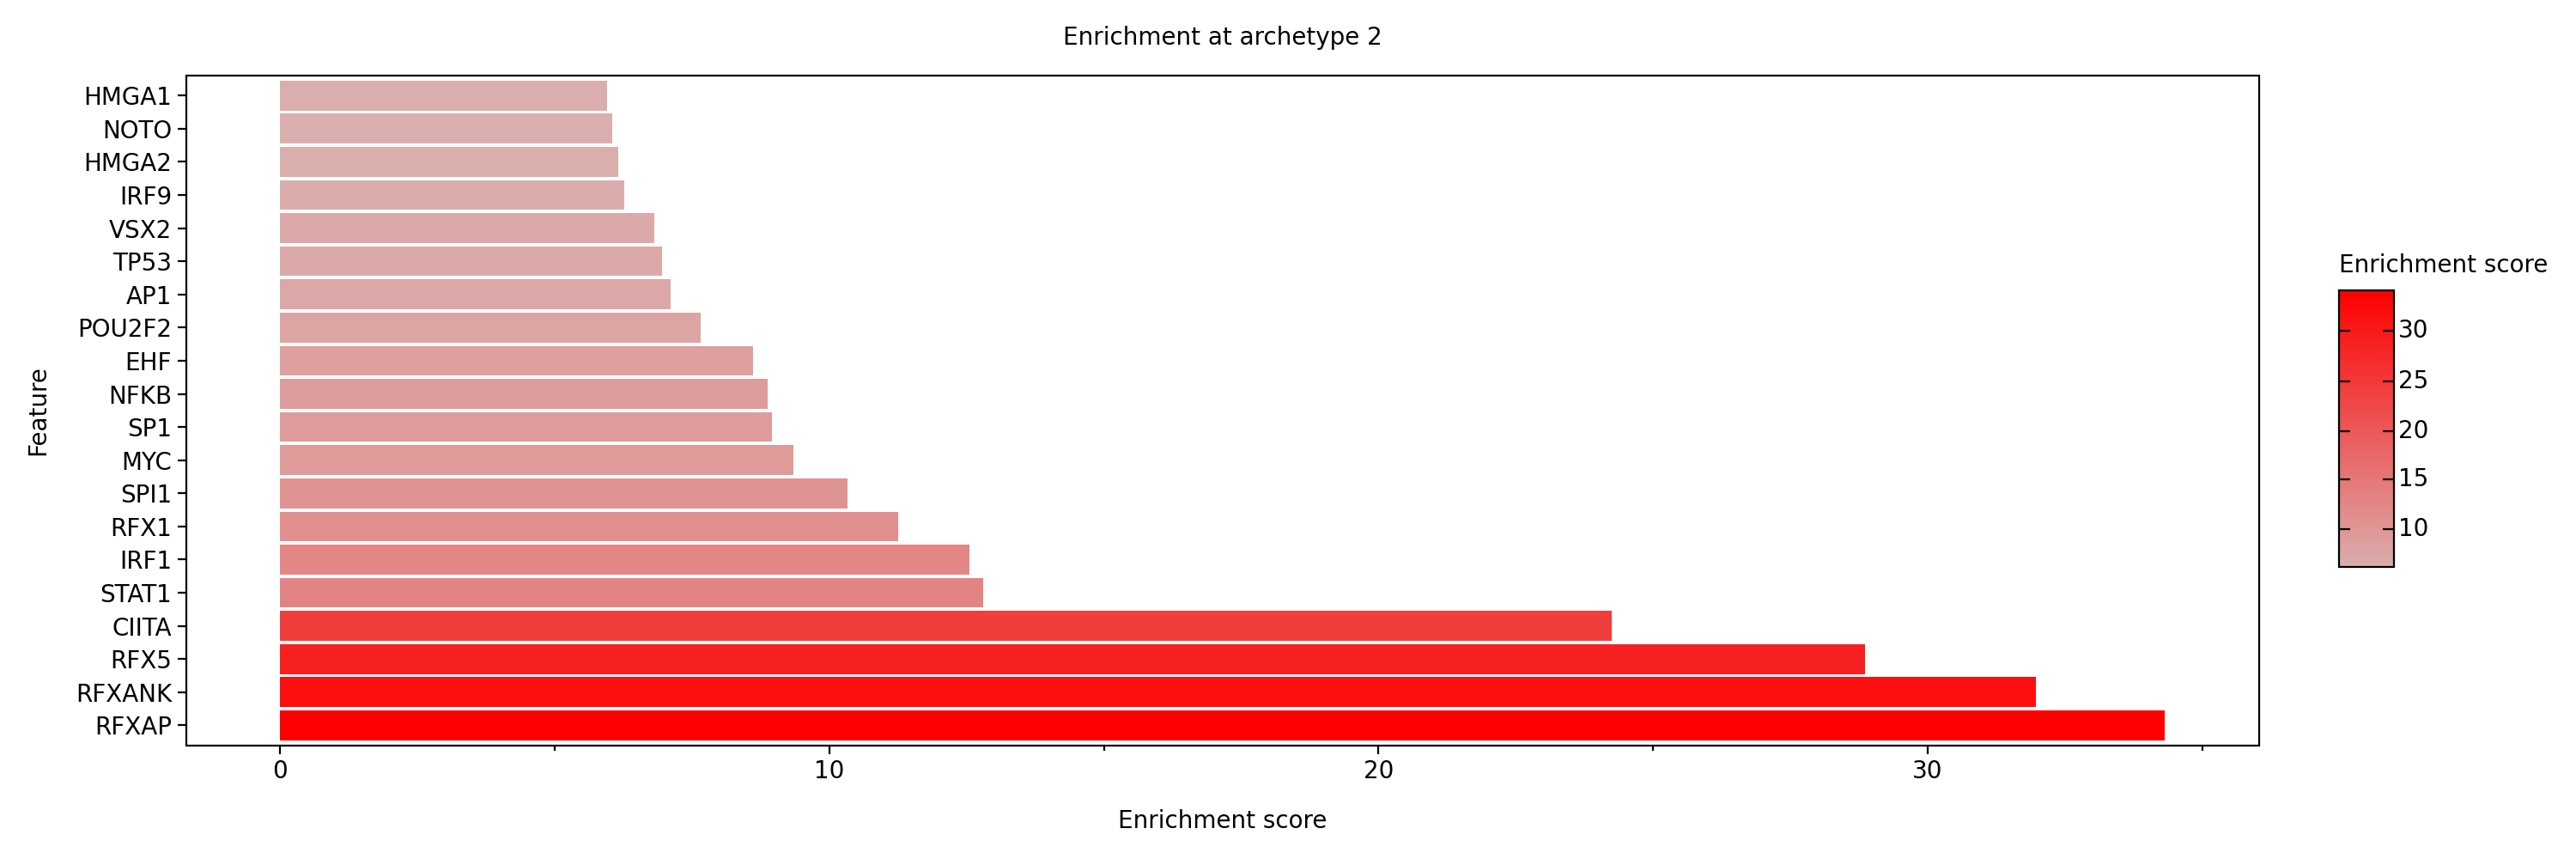

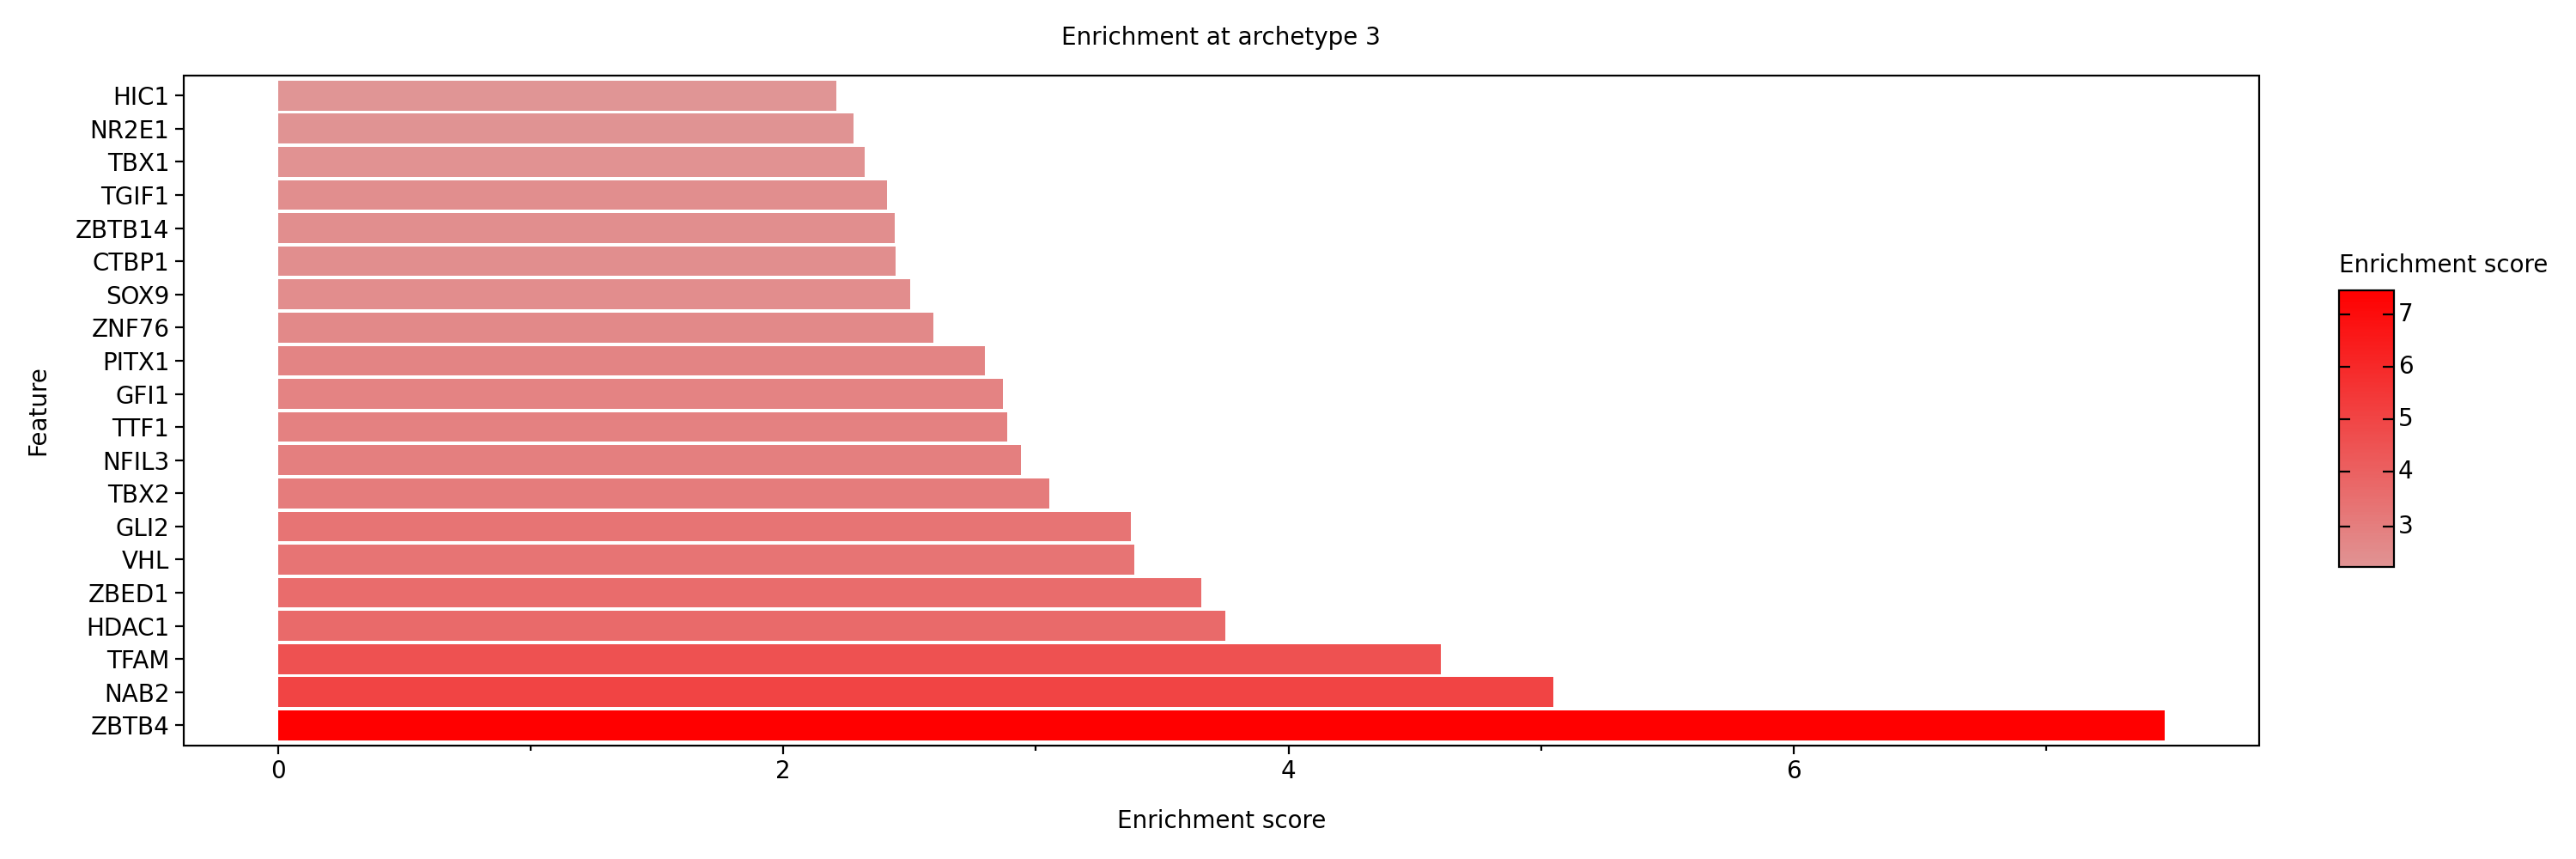

In [59]:
pt.barplot_functional_enrichment(top_processes_collectri)

archetype 0 associtaed with flare:

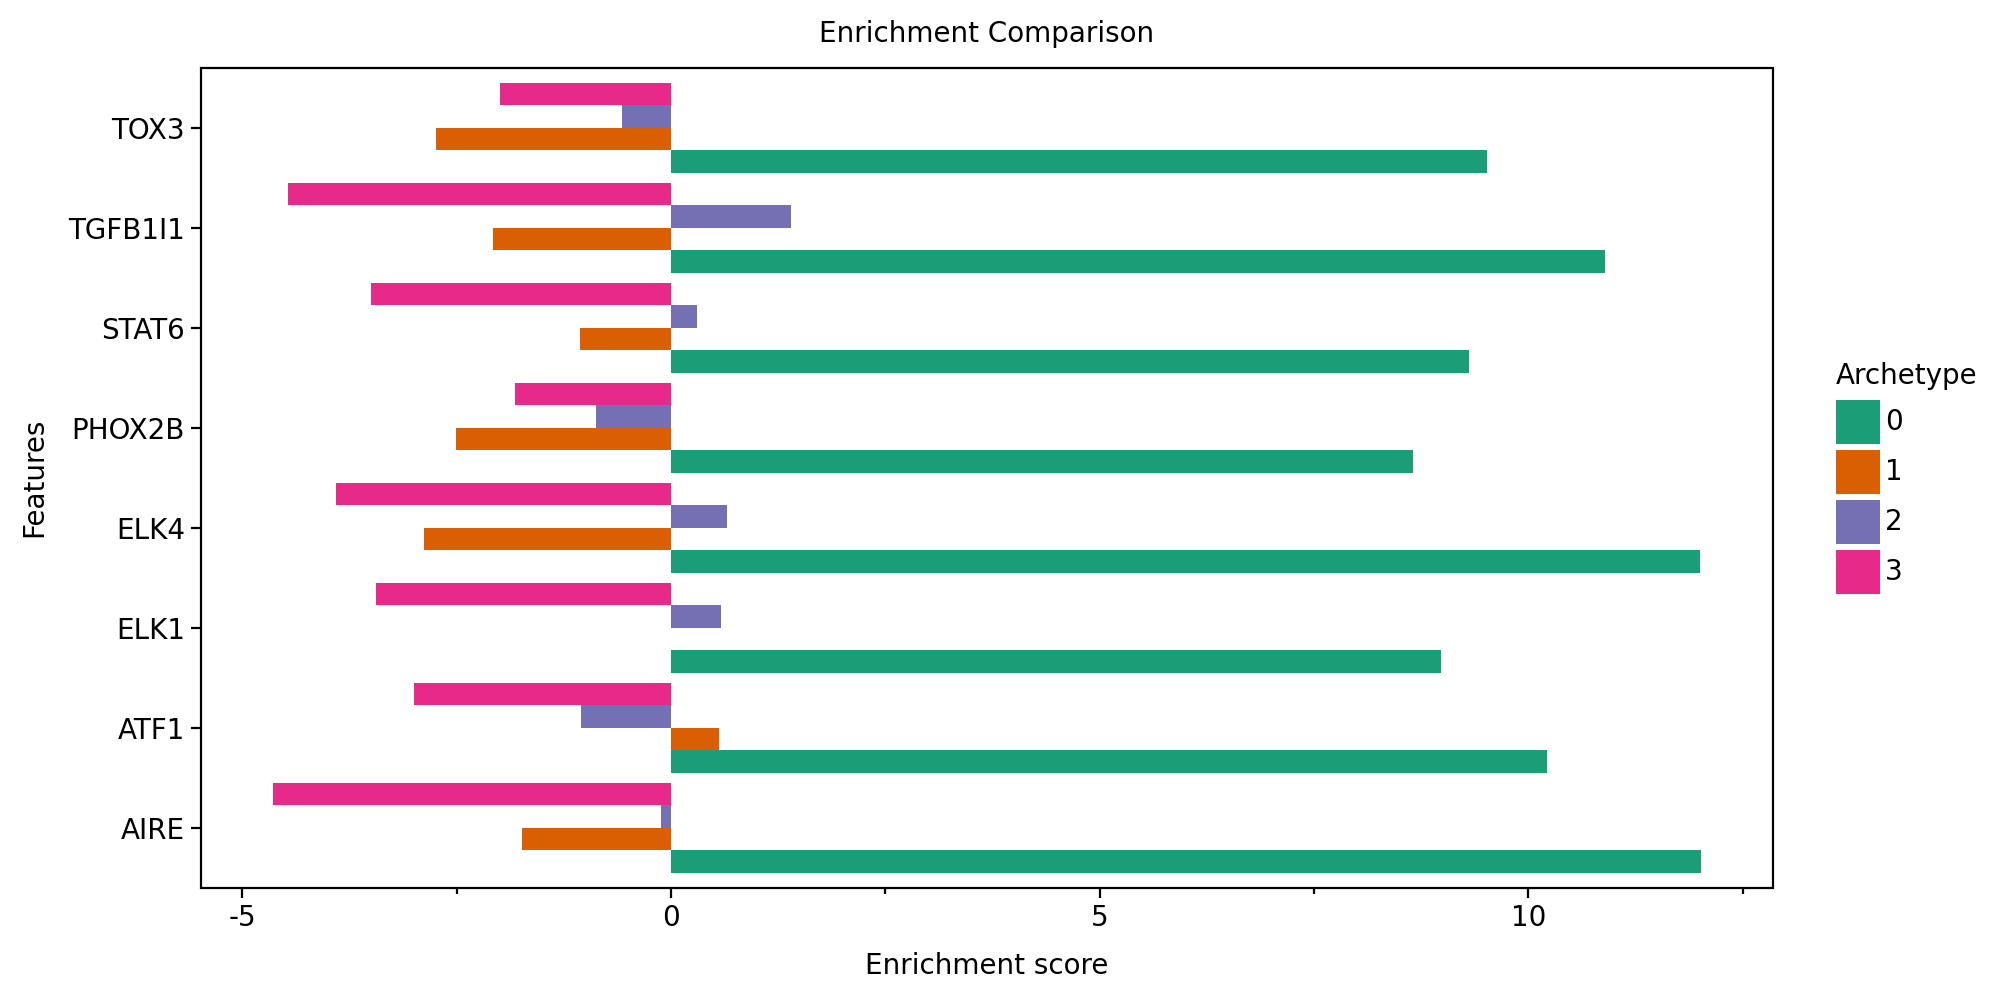

In [60]:
pt.barplot_enrichment_comparison(acts_ulm_est_collectri, specific_processes_collectri["archetype_0"].columns)

Archetype 3 associtaed with healthy:

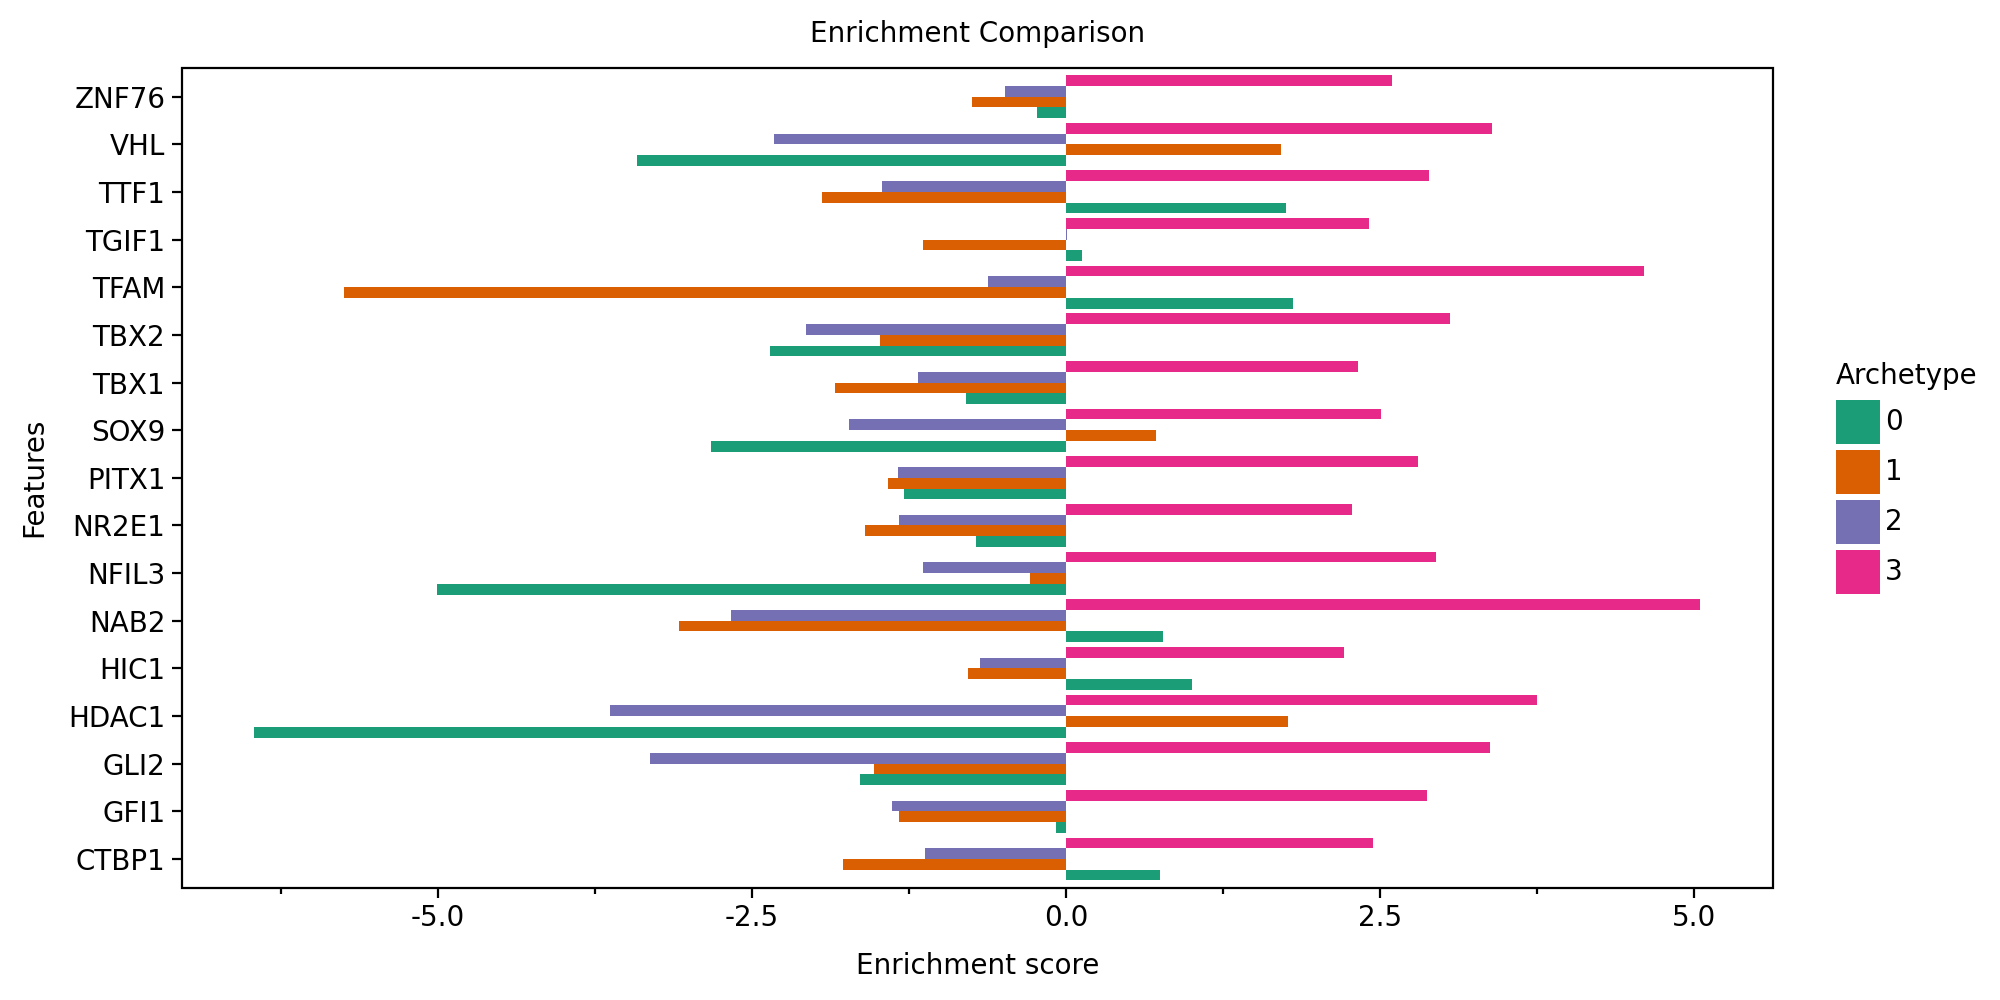

In [61]:
pt.barplot_enrichment_comparison(acts_ulm_est_collectri, specific_processes_collectri["archetype_3"].columns)